<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# MIRI Imaging TSO Pipeline Notebook

**Authors**: Ian Wong; MIRI branch<br>
**Last Updated**: December 10, 2025<br>
**Pipeline Version**: 1.20.2 (Build 12.1)

**Purpose**:<br>
This notebook provides a framework for processing generic Mid-Infrared Instrument 
(MIRI) Imaging time series observations (TSO) data through all
three James Webb Space Telescope (JWST) pipeline stages.  The data are assumed
to be located in the observation directory located in the path set up below.
It should not be necessary to edit any cells other than in the
[Configuration](#1.-Configuration) section unless modifying the standard
pipeline processing options.

A significant portion of the data processing workflow for Imaging TSOs is identical to the methods used to process (non-TSO) Imaging observations, and much of this notebook mirrors the corresponding steps shown in the general MIRI Imaging notebook.

**Data**:<br>
This example is set up to use observations of a secondary eclipse event of LHS-1478b, which were obtained as part of Cycle 1 General Observers Proposal ID (PID) 3730 Observation 13 (PI: H. Diamond-Lowe). A continuous series of 964 integrations of the target was collected with the F1500W filter. No dithering was carried out, as is standard practice for Imaging TSOs. The SUB256 subarray readout was used. The example uncalibrated data will be downloaded automatically unless disabled (i.e., to run with user-supplied local files instead).<br>

Most Imaging TSO programs do not have dedicated background observations, with background flux subtraction handled using pixels near the target in the science observations. This version of the notebook does not accommodate cases where dedicated background subtraction is needed. Consult the general MIRI Imaging notebook for a detailed implementation of dedicated background exposures.

**JWST pipeline version and CRDS context**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.** Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-ifu-known-issues#gsc.tab=0) for this build are noted in the notebook.<br>

**Updates**:<br>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Feb 2 2025: Notebook created.<br>
May 5, 2025: Updated to jwst 1.18.0 (no significant changes)<br>
July 16, 2025: Updated to jwst 1.19.1 (no significant changes)<br>
December 10, 2025: Updated to jwst 1.20.2 (no significant changes)

<hr style="border:1px solid gray"> </hr>

## Table of Contents
1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup (ignore if not using demo data)](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
3. [Detector1 Pipeline](#5.-Detector1-Pipeline)
4. [Image2 Pipeline](#6.-Image2-Pipeline)
5. [Tso3 Pipeline](#7.-Tso3-Pipeline)
6. [Visualize the photometric light curve](#8.-Visualize-the-photometric-light-curve)

<hr style="border:1px solid gray"> </hr>

## 1. Configuration

### Install dependencies
To make sure that the pipeline version is compatabile with this notebook and the required dependencies and packages are installed,
it is recommended that users create a new dedicated conda environment and install the provided
`requirements.txt` file before starting this notebook: <br>
```
conda create -n lrs_demo python=3.11
conda activate lrs_demo
pip install -r requirements.txt
```

### Set run parameters
Set basic parameters to use with the notebook. These will affect
what observation is used, where the uncalibrated data are located (if already on disk), which
pipeline modules to run on the data, and whether background subtraction is carried out. The list of parameters are:

* demo_mode
* directory with data
* pipeline steps

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode, this
notebook will download the example data from the
Barbara A. Mikulski Archive for Space Telescopes ([MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)) and process them through the pipeline.
All input and output data will be stored in the local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> to process user-specified data that have already
been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode and processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    basedir = os.path.join(os.getcwd(), '')

    # Point to where science observation data are stored.
    # Assumes uncalibrated data in sci_dir/uncal/, with the results stored in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(basedir, 'imaging_demo_data/PID03730Obs013/')

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
do_det1 = True  # calwebb_detector1
do_image2 = True  # calwebb_image2
do_tso3 = True  # calwebb_tso3
do_viz = True  # Visualize calwebb_tso3 results

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.<br>

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#%env CRDS_CONTEXT jwst_1293.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')

# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2. Package Imports

Automatically import necessary Python packages for use in the data processing and visualization.

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
from pathlib import Path

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files and downloading demo files
from astropy.io import ascii

# -----------------------Astrquery Imports-----------------------------------
# Utilities to download data 
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

# ----------------------JWST calibration pipeline--------------------------
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Tso3Pipeline

# JWST pipeline utilities
from jwst import datamodels
#from jwst.datamodels import ImageModel
from jwst.associations import asn_from_list as afl  # Tools for creating association files
#from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

JWST Calibration Pipeline Version: 1.20.2


CRDS - INFO -  Calibration SW Found: jwst 1.20.2 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.20.2.dist-info)


Using CRDS Context: jwst_1464.pmap


In [6]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3. Demo Mode Setup (ignore if not using demo data)

If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [7]:
# Set up the program information and paths for demo program
if demo_mode:
    program = '03730'
    sci_obs = "013"
    basedir = os.path.join('.', 'imaging_demo_data')
    sci_dir = os.path.join(basedir, 'PID' + program + 'Obs' + sci_obs)
    uncal_dir = os.path.join(sci_dir, 'uncal')

    # Ensure filepaths for input data exists
    os.makedirs(uncal_dir, exist_ok=True)

Identify list of uncalibrated files associated with the observations.

In [8]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IMAGE"], provenance_name=["CALJWST"], obs_id=['jw' + program + sci_obs + '*'])

In [9]:
# Turn the list of observations into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE',
                           'productSubGroupDescription': 'UNCAL',
                           'calib_level': [1]}}

    # Science files
    files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            files_to_download.extend(filtered_products['dataURI'])

    print("Number of files selected for downloading: ", len(files_to_download))

Number of files selected for downloading:  5


Due to data file size constraints, long TSOs have their exposures broken up into multiple segment files. In this case, there should be a total of 5 segments, which together comprise the full duration of the time series observation. 

Now, download all the uncal files and place them into the appropriate
directories.<br>

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file
may be incomplete, and cause crashes later on!
</div>

In [10]:
if demo_mode:
    for filename in files_to_download:
        obs_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_dir, Path(filename).name))

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup

Set up detailed paths to input/output stages here. When running this notebook outside of demo mode, the uncalibrated pipeline input files must be placed into the appropriate directories before proceeding to the JWST pipeline processing.

In [11]:
# Define output subdirectories to keep the data products organized
uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here
tso3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_tso3 pipeline outputs will go here

# Create desired output directories, if needed
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(image2_dir, exist_ok=True)
os.makedirs(tso3_dir, exist_ok=True)

<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the
[Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1)
stage of the pipeline to apply detector level calibrations and create a
countrate data product where slopes are fitted to the integration ramps.
The `*_rate.fits` products are 2D countrate images, averaged over all
integrations within each segment. Meanwhile, 3D countrate data stacks containing an image for each integration (`*_rateints.fits` files) are also
created, which will be used in the subsequent stage to preserve the temporal information in the exposure series.<br>

When processing MIRI Imaging TSOs, the Detector1 pipeline skips a few pipeline steps by default that would otherwise be run for non-TSO data. These are `rscd` and `firstframe`, which both essentially instruct the pipeline to ignore initial frames within each ramp. The motivation behind the different settings here is that most TSOs have short ramps, and ignoring too many frames can leave too little of the ramp to adequately produce a ramp slope fit. See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1 for a detailed overview of the various pipeline steps that comprise Detector1.

As of CRDS context `jwst_1201.pmap` and later, the
`jump` step
in the Detector1 pipeline allows for the removal of residuals associated
with [showers](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
for MIRI Imaging observations, but only for data taken with filters shortward (inclusive) of F1500W.
Setting the `find_showers` parameter to `True` in the `jump` step activates this functionality. The default parameters for this correction are specified in the `pars-jumpstep` parameter reference files. Users may wish to alter parameters to optimize removal of
shower residuals. Available parameters are discussed in the
[Detection and Flagging of Showers and Snowballs in JWST Technical Report (Regan 2023)](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008545.pdf).

In [12]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'] = {}, {}, {}
det1dict['saturation'], det1dict['firstframe'], det1dict['lastframe'] = {}, {}, {}
det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['jump'] = {}, {}, {}
det1dict['ramp_fit'], det1dict['gain_scale'], det1dict['clean_flicker_noise'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped
#det1dict['refpix']['skip'] = True
#det1dict['jump']['find_showers'] = True  # Turn on detection of cosmic ray showers
#det1dict['clean_flicker_noise']['skip'] = True  # Skipped by default

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Alter parameters to optimize removal of shower residuals (example)
#det1dict['jump']['after_jump_flag_dn1'] = X  # A floating point value in units of DN
#det1dict['jump']['after_jump_flag_time1'] = x.x  # A floating point value in units of seconds

Grab all of the uncalibrated files, which comprise the full time series observation.

In [13]:
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))
print(uncal_files)
print('Found ' + str(len(uncal_files)) + ' input uncal files')

['./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg001_mirimage_uncal.fits', './imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg002_mirimage_uncal.fits', './imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg003_mirimage_uncal.fits', './imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg004_mirimage_uncal.fits', './imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg005_mirimage_uncal.fits']
Found 5 input uncal files


Run the Detector1 pipeline on the selected uncalibrated data using the call method. For long TSOs with full array readouts, this process may take more than 10 minutes per file, particularly if <code>find_showers = True</code>.

In [14]:
# Run the pipeline on the selected uncal files one by one with the custom parameter dictionary 
if do_det1:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing...')

2025-12-18 19:37:47,768 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 212 files) (0 / 762.3 K bytes)


2025-12-18 19:37:47,942 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0063.rmap    5.7 K bytes  (2 / 212 files) (694 / 762.3 K bytes)


2025-12-18 19:37:48,134 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0058.imap        385 bytes  (3 / 212 files) (6.4 K / 762.3 K bytes)


2025-12-18 19:37:48,304 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 212 files) (6.8 K / 762.3 K bytes)


2025-12-18 19:37:48,499 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 212 files) (8.2 K / 762.3 K bytes)


2025-12-18 19:37:48,672 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0087.rmap   38.3 K bytes  (6 / 212 files) (9.0 K / 762.3 K bytes)


2025-12-18 19:37:48,920 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0002.rmap      704 bytes  (7 / 212 files) (47.3 K / 762.3 K bytes)


2025-12-18 19:37:49,089 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0027.rmap   20.6 K bytes  (8 / 212 files) (48.0 K / 762.3 K bytes)


2025-12-18 19:37:49,311 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 212 files) (68.7 K / 762.3 K bytes)


2025-12-18 19:37:49,480 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 212 files) (70.7 K / 762.3 K bytes)


2025-12-18 19:37:49,647 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 212 files) (72.2 K / 762.3 K bytes)


2025-12-18 19:37:49,835 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_psf_0002.rmap      687 bytes  (12 / 212 files) (74.8 K / 762.3 K bytes)


2025-12-18 19:37:49,996 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (13 / 212 files) (75.5 K / 762.3 K bytes)


2025-12-18 19:37:50,159 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (14 / 212 files) (76.2 K / 762.3 K bytes)


2025-12-18 19:37:50,358 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0011.rmap    1.2 K bytes  (15 / 212 files) (77.1 K / 762.3 K bytes)


2025-12-18 19:37:50,531 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (16 / 212 files) (78.3 K / 762.3 K bytes)


2025-12-18 19:37:50,693 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (17 / 212 files) (79.1 K / 762.3 K bytes)


2025-12-18 19:37:50,861 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (18 / 212 files) (81.2 K / 762.3 K bytes)


2025-12-18 19:37:51,029 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-refpixstep_0003.rmap      910 bytes  (19 / 212 files) (81.9 K / 762.3 K bytes)


2025-12-18 19:37:51,201 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (20 / 212 files) (82.8 K / 762.3 K bytes)


2025-12-18 19:37:51,372 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (21 / 212 files) (84.0 K / 762.3 K bytes)


2025-12-18 19:37:51,547 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (22 / 212 files) (84.8 K / 762.3 K bytes)


2025-12-18 19:37:51,718 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (23 / 212 files) (85.8 K / 762.3 K bytes)


2025-12-18 19:37:51,888 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (24 / 212 files) (86.8 K / 762.3 K bytes)


2025-12-18 19:37:52,058 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (25 / 212 files) (87.7 K / 762.3 K bytes)


2025-12-18 19:37:52,228 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (26 / 212 files) (89.5 K / 762.3 K bytes)


2025-12-18 19:37:52,399 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0017.rmap    1.6 K bytes  (27 / 212 files) (90.8 K / 762.3 K bytes)


2025-12-18 19:37:52,569 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (28 / 212 files) (92.4 K / 762.3 K bytes)


2025-12-18 19:37:52,730 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0044.rmap    4.3 K bytes  (29 / 212 files) (93.6 K / 762.3 K bytes)


2025-12-18 19:37:52,903 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (30 / 212 files) (97.9 K / 762.3 K bytes)


2025-12-18 19:37:53,074 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (31 / 212 files) (99.5 K / 762.3 K bytes)


2025-12-18 19:37:53,242 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (32 / 212 files) (100.4 K / 762.3 K bytes)


2025-12-18 19:37:53,403 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (33 / 212 files) (101.9 K / 762.3 K bytes)


2025-12-18 19:37:53,570 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (34 / 212 files) (103.4 K / 762.3 K bytes)


2025-12-18 19:37:53,732 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (35 / 212 files) (104.9 K / 762.3 K bytes)


2025-12-18 19:37:53,904 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (36 / 212 files) (106.7 K / 762.3 K bytes)


2025-12-18 19:37:54,074 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (37 / 212 files) (107.9 K / 762.3 K bytes)


2025-12-18 19:37:54,246 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (38 / 212 files) (112.9 K / 762.3 K bytes)


2025-12-18 19:37:54,414 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0028.rmap    7.2 K bytes  (39 / 212 files) (116.7 K / 762.3 K bytes)


2025-12-18 19:37:54,585 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (40 / 212 files) (123.9 K / 762.3 K bytes)


2025-12-18 19:37:54,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (41 / 212 files) (126.2 K / 762.3 K bytes)


2025-12-18 19:37:54,931 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (42 / 212 files) (131.9 K / 762.3 K bytes)


2025-12-18 19:37:55,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0083.rmap   36.4 K bytes  (43 / 212 files) (133.0 K / 762.3 K bytes)


2025-12-18 19:37:55,323 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (44 / 212 files) (169.4 K / 762.3 K bytes)


2025-12-18 19:37:55,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (45 / 212 files) (170.4 K / 762.3 K bytes)


2025-12-18 19:37:55,648 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (46 / 212 files) (171.7 K / 762.3 K bytes)


2025-12-18 19:37:55,819 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (47 / 212 files) (173.0 K / 762.3 K bytes)


2025-12-18 19:37:55,990 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (48 / 212 files) (174.8 K / 762.3 K bytes)


2025-12-18 19:37:56,152 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (49 / 212 files) (181.1 K / 762.3 K bytes)


2025-12-18 19:37:56,322 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0420.imap     5.8 K bytes  (50 / 212 files) (186.7 K / 762.3 K bytes)


2025-12-18 19:37:56,489 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0008.rmap      897 bytes  (51 / 212 files) (192.5 K / 762.3 K bytes)


2025-12-18 19:37:56,648 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (52 / 212 files) (193.4 K / 762.3 K bytes)


2025-12-18 19:37:56,816 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (53 / 212 files) (194.1 K / 762.3 K bytes)


2025-12-18 19:37:57,126 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (54 / 212 files) (194.8 K / 762.3 K bytes)


2025-12-18 19:37:57,300 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0033.rmap    8.0 K bytes  (55 / 212 files) (196.1 K / 762.3 K bytes)


2025-12-18 19:37:57,471 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0016.rmap    3.1 K bytes  (56 / 212 files) (204.1 K / 762.3 K bytes)


2025-12-18 19:37:57,642 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (57 / 212 files) (207.2 K / 762.3 K bytes)


2025-12-18 19:37:57,810 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (58 / 212 files) (209.6 K / 762.3 K bytes)


2025-12-18 19:37:57,981 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0002.rmap      700 bytes  (59 / 212 files) (210.6 K / 762.3 K bytes)


2025-12-18 19:37:58,167 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (60 / 212 files) (211.3 K / 762.3 K bytes)


2025-12-18 19:37:58,341 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (61 / 212 files) (212.1 K / 762.3 K bytes)


2025-12-18 19:37:58,509 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0037.rmap    1.3 K bytes  (62 / 212 files) (213.1 K / 762.3 K bytes)


2025-12-18 19:37:58,686 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (63 / 212 files) (214.4 K / 762.3 K bytes)


2025-12-18 19:37:58,855 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (64 / 212 files) (215.1 K / 762.3 K bytes)


2025-12-18 19:37:59,025 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0005.rmap      818 bytes  (65 / 212 files) (215.8 K / 762.3 K bytes)


2025-12-18 19:37:59,197 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (66 / 212 files) (216.6 K / 762.3 K bytes)


2025-12-18 19:37:59,369 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (67 / 212 files) (217.5 K / 762.3 K bytes)


2025-12-18 19:37:59,544 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0009.rmap    1.2 K bytes  (68 / 212 files) (220.7 K / 762.3 K bytes)


2025-12-18 19:37:59,712 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (69 / 212 files) (221.9 K / 762.3 K bytes)


2025-12-18 19:37:59,875 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (70 / 212 files) (224.2 K / 762.3 K bytes)


2025-12-18 19:38:00,036 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (71 / 212 files) (224.9 K / 762.3 K bytes)


2025-12-18 19:38:00,214 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (72 / 212 files) (227.6 K / 762.3 K bytes)


2025-12-18 19:38:00,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (73 / 212 files) (233.9 K / 762.3 K bytes)


2025-12-18 19:38:00,550 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (74 / 212 files) (235.0 K / 762.3 K bytes)


2025-12-18 19:38:00,722 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (75 / 212 files) (236.0 K / 762.3 K bytes)


2025-12-18 19:38:00,890 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (76 / 212 files) (236.9 K / 762.3 K bytes)


2025-12-18 19:38:01,060 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0005.rmap    5.7 K bytes  (77 / 212 files) (237.5 K / 762.3 K bytes)


2025-12-18 19:38:01,234 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-backgroundstep_0003.rmap      822 bytes  (78 / 212 files) (243.1 K / 762.3 K bytes)


2025-12-18 19:38:01,408 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (79 / 212 files) (243.9 K / 762.3 K bytes)


2025-12-18 19:38:01,592 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0024.rmap    1.5 K bytes  (80 / 212 files) (244.6 K / 762.3 K bytes)


2025-12-18 19:38:01,764 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (81 / 212 files) (246.1 K / 762.3 K bytes)


2025-12-18 19:38:01,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (82 / 212 files) (247.0 K / 762.3 K bytes)


2025-12-18 19:38:02,106 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (83 / 212 files) (247.7 K / 762.3 K bytes)


2025-12-18 19:38:02,277 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (84 / 212 files) (248.5 K / 762.3 K bytes)


2025-12-18 19:38:02,442 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (85 / 212 files) (254.3 K / 762.3 K bytes)


2025-12-18 19:38:02,620 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (86 / 212 files) (255.2 K / 762.3 K bytes)


2025-12-18 19:38:02,789 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (87 / 212 files) (256.1 K / 762.3 K bytes)


2025-12-18 19:38:02,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (88 / 212 files) (256.6 K / 762.3 K bytes)


2025-12-18 19:38:03,137 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0037.rmap    8.1 K bytes  (89 / 212 files) (260.1 K / 762.3 K bytes)


2025-12-18 19:38:03,312 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0005.rmap    3.1 K bytes  (90 / 212 files) (268.2 K / 762.3 K bytes)


2025-12-18 19:38:03,485 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (91 / 212 files) (271.2 K / 762.3 K bytes)


2025-12-18 19:38:03,771 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (92 / 212 files) (273.9 K / 762.3 K bytes)


2025-12-18 19:38:03,948 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (93 / 212 files) (278.2 K / 762.3 K bytes)


2025-12-18 19:38:04,120 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0292.imap      5.8 K bytes  (94 / 212 files) (279.6 K / 762.3 K bytes)


2025-12-18 19:38:04,290 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0011.rmap      996 bytes  (95 / 212 files) (285.3 K / 762.3 K bytes)


2025-12-18 19:38:04,459 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (96 / 212 files) (286.3 K / 762.3 K bytes)


2025-12-18 19:38:04,629 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (97 / 212 files) (287.2 K / 762.3 K bytes)


2025-12-18 19:38:04,816 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (98 / 212 files) (288.8 K / 762.3 K bytes)


2025-12-18 19:38:04,987 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0020.rmap   19.6 K bytes  (99 / 212 files) (290.5 K / 762.3 K bytes)


2025-12-18 19:38:05,216 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0024.rmap    8.0 K bytes  (100 / 212 files) (310.0 K / 762.3 K bytes)


2025-12-18 19:38:05,390 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0003.rmap      671 bytes  (101 / 212 files) (318.0 K / 762.3 K bytes)


2025-12-18 19:38:05,560 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (102 / 212 files) (318.7 K / 762.3 K bytes)


2025-12-18 19:38:05,732 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_regions_0002.rmap      725 bytes  (103 / 212 files) (321.5 K / 762.3 K bytes)


2025-12-18 19:38:05,902 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0027.rmap   26.6 K bytes  (104 / 212 files) (322.2 K / 762.3 K bytes)


2025-12-18 19:38:06,172 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (105 / 212 files) (348.8 K / 762.3 K bytes)


2025-12-18 19:38:06,402 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (106 / 212 files) (377.2 K / 762.3 K bytes)


2025-12-18 19:38:06,572 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (107 / 212 files) (380.5 K / 762.3 K bytes)


2025-12-18 19:38:06,743 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (108 / 212 files) (382.1 K / 762.3 K bytes)


2025-12-18 19:38:06,913 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (109 / 212 files) (384.1 K / 762.3 K bytes)


2025-12-18 19:38:07,092 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tsophotometrystep_0003.rmap    1.1 K bytes  (110 / 212 files) (388.6 K / 762.3 K bytes)


2025-12-18 19:38:07,265 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0009.rmap      984 bytes  (111 / 212 files) (389.6 K / 762.3 K bytes)


2025-12-18 19:38:07,437 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (112 / 212 files) (390.6 K / 762.3 K bytes)


2025-12-18 19:38:07,605 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (113 / 212 files) (395.3 K / 762.3 K bytes)


2025-12-18 19:38:07,783 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (114 / 212 files) (396.0 K / 762.3 K bytes)


2025-12-18 19:38:07,961 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (115 / 212 files) (396.9 K / 762.3 K bytes)


2025-12-18 19:38:08,131 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (116 / 212 files) (397.7 K / 762.3 K bytes)


2025-12-18 19:38:08,300 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0006.rmap    1.7 K bytes  (117 / 212 files) (398.8 K / 762.3 K bytes)


2025-12-18 19:38:08,470 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (118 / 212 files) (400.6 K / 762.3 K bytes)


2025-12-18 19:38:08,643 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (119 / 212 files) (401.4 K / 762.3 K bytes)


2025-12-18 19:38:08,815 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-backgroundstep_0003.rmap      822 bytes  (120 / 212 files) (402.0 K / 762.3 K bytes)


2025-12-18 19:38:08,993 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0013.rmap    4.8 K bytes  (121 / 212 files) (402.9 K / 762.3 K bytes)


2025-12-18 19:38:09,163 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (122 / 212 files) (407.6 K / 762.3 K bytes)


2025-12-18 19:38:09,333 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (123 / 212 files) (410.0 K / 762.3 K bytes)


2025-12-18 19:38:09,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (124 / 212 files) (412.0 K / 762.3 K bytes)


2025-12-18 19:38:09,672 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (125 / 212 files) (414.1 K / 762.3 K bytes)


2025-12-18 19:38:09,944 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (126 / 212 files) (465.8 K / 762.3 K bytes)


2025-12-18 19:38:10,113 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (127 / 212 files) (467.2 K / 762.3 K bytes)


2025-12-18 19:38:10,281 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (128 / 212 files) (468.4 K / 762.3 K bytes)


2025-12-18 19:38:10,451 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0034.rmap   53.4 K bytes  (129 / 212 files) (468.9 K / 762.3 K bytes)


2025-12-18 19:38:10,780 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0049.rmap   29.6 K bytes  (130 / 212 files) (522.3 K / 762.3 K bytes)


2025-12-18 19:38:11,057 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_bkg_0002.rmap    7.0 K bytes  (131 / 212 files) (551.9 K / 762.3 K bytes)


2025-12-18 19:38:11,230 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (132 / 212 files) (558.9 K / 762.3 K bytes)


2025-12-18 19:38:11,504 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (133 / 212 files) (592.4 K / 762.3 K bytes)


2025-12-18 19:38:11,682 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (134 / 212 files) (596.6 K / 762.3 K bytes)


2025-12-18 19:38:11,851 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0333.imap      5.7 K bytes  (135 / 212 files) (597.9 K / 762.3 K bytes)


2025-12-18 19:38:12,022 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0029.rmap    1.0 K bytes  (136 / 212 files) (603.6 K / 762.3 K bytes)


2025-12-18 19:38:12,196 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (137 / 212 files) (604.6 K / 762.3 K bytes)


2025-12-18 19:38:12,368 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (138 / 212 files) (605.5 K / 762.3 K bytes)


2025-12-18 19:38:12,547 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0047.rmap    5.9 K bytes  (139 / 212 files) (606.5 K / 762.3 K bytes)


2025-12-18 19:38:12,731 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (140 / 212 files) (612.4 K / 762.3 K bytes)


2025-12-18 19:38:12,900 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (141 / 212 files) (613.6 K / 762.3 K bytes)


2025-12-18 19:38:13,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (142 / 212 files) (614.6 K / 762.3 K bytes)


2025-12-18 19:38:13,246 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (143 / 212 files) (615.4 K / 762.3 K bytes)


2025-12-18 19:38:13,420 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0036.rmap    4.4 K bytes  (144 / 212 files) (619.3 K / 762.3 K bytes)


2025-12-18 19:38:13,587 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (145 / 212 files) (623.6 K / 762.3 K bytes)


2025-12-18 19:38:13,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (146 / 212 files) (625.3 K / 762.3 K bytes)


2025-12-18 19:38:13,932 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0008.rmap    2.6 K bytes  (147 / 212 files) (627.4 K / 762.3 K bytes)


2025-12-18 19:38:14,110 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0062.rmap    3.7 K bytes  (148 / 212 files) (630.0 K / 762.3 K bytes)


2025-12-18 19:38:14,280 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (149 / 212 files) (633.8 K / 762.3 K bytes)


2025-12-18 19:38:14,453 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (150 / 212 files) (634.6 K / 762.3 K bytes)


2025-12-18 19:38:14,621 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (151 / 212 files) (635.5 K / 762.3 K bytes)


2025-12-18 19:38:14,806 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tsophotometrystep_0003.rmap    2.7 K bytes  (152 / 212 files) (637.4 K / 762.3 K bytes)


2025-12-18 19:38:14,976 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0011.rmap      886 bytes  (153 / 212 files) (640.0 K / 762.3 K bytes)


2025-12-18 19:38:15,145 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0013.rmap    1.4 K bytes  (154 / 212 files) (640.9 K / 762.3 K bytes)


2025-12-18 19:38:15,317 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (155 / 212 files) (642.3 K / 762.3 K bytes)


2025-12-18 19:38:15,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (156 / 212 files) (644.2 K / 762.3 K bytes)


2025-12-18 19:38:15,664 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (157 / 212 files) (644.9 K / 762.3 K bytes)


2025-12-18 19:38:15,842 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (158 / 212 files) (645.6 K / 762.3 K bytes)


2025-12-18 19:38:16,016 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (159 / 212 files) (649.0 K / 762.3 K bytes)


2025-12-18 19:38:16,189 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (160 / 212 files) (650.6 K / 762.3 K bytes)


2025-12-18 19:38:16,362 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (161 / 212 files) (651.7 K / 762.3 K bytes)


2025-12-18 19:38:16,532 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (162 / 212 files) (652.5 K / 762.3 K bytes)


2025-12-18 19:38:16,703 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (163 / 212 files) (653.3 K / 762.3 K bytes)


2025-12-18 19:38:16,890 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (164 / 212 files) (654.9 K / 762.3 K bytes)


2025-12-18 19:38:17,059 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (165 / 212 files) (655.7 K / 762.3 K bytes)


2025-12-18 19:38:17,226 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-backgroundstep_0003.rmap      814 bytes  (166 / 212 files) (656.4 K / 762.3 K bytes)


2025-12-18 19:38:17,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (167 / 212 files) (657.2 K / 762.3 K bytes)


2025-12-18 19:38:17,569 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (168 / 212 files) (659.4 K / 762.3 K bytes)


2025-12-18 19:38:17,737 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0032.rmap    7.3 K bytes  (169 / 212 files) (661.3 K / 762.3 K bytes)


2025-12-18 19:38:17,908 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (170 / 212 files) (668.6 K / 762.3 K bytes)


2025-12-18 19:38:18,080 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (171 / 212 files) (671.4 K / 762.3 K bytes)


2025-12-18 19:38:18,256 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (172 / 212 files) (672.1 K / 762.3 K bytes)


2025-12-18 19:38:18,432 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (173 / 212 files) (676.1 K / 762.3 K bytes)


2025-12-18 19:38:18,601 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (174 / 212 files) (677.5 K / 762.3 K bytes)


2025-12-18 19:38:18,775 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0071.rmap   15.7 K bytes  (175 / 212 files) (681.4 K / 762.3 K bytes)


2025-12-18 19:38:18,990 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0027.rmap    2.1 K bytes  (176 / 212 files) (697.1 K / 762.3 K bytes)


2025-12-18 19:38:19,157 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0021.rmap    1.4 K bytes  (177 / 212 files) (699.2 K / 762.3 K bytes)


2025-12-18 19:38:19,326 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0004.rmap      663 bytes  (178 / 212 files) (700.6 K / 762.3 K bytes)


2025-12-18 19:38:19,493 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (179 / 212 files) (701.3 K / 762.3 K bytes)


2025-12-18 19:38:19,662 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0042.rmap    4.8 K bytes  (180 / 212 files) (701.8 K / 762.3 K bytes)


2025-12-18 19:38:19,829 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0037.rmap    4.4 K bytes  (181 / 212 files) (706.6 K / 762.3 K bytes)


2025-12-18 19:38:20,005 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (182 / 212 files) (711.0 K / 762.3 K bytes)


2025-12-18 19:38:20,173 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_bkg_0003.rmap      712 bytes  (183 / 212 files) (711.8 K / 762.3 K bytes)


2025-12-18 19:38:20,342 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (184 / 212 files) (712.5 K / 762.3 K bytes)


2025-12-18 19:38:20,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0022.rmap    5.0 K bytes  (185 / 212 files) (713.3 K / 762.3 K bytes)


2025-12-18 19:38:20,697 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (186 / 212 files) (718.3 K / 762.3 K bytes)


2025-12-18 19:38:20,864 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0468.imap        5.9 K bytes  (187 / 212 files) (719.6 K / 762.3 K bytes)


2025-12-18 19:38:21,039 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (188 / 212 files) (725.5 K / 762.3 K bytes)


2025-12-18 19:38:21,207 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (189 / 212 files) (726.4 K / 762.3 K bytes)


2025-12-18 19:38:21,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (190 / 212 files) (727.3 K / 762.3 K bytes)


2025-12-18 19:38:21,559 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (191 / 212 files) (731.1 K / 762.3 K bytes)


2025-12-18 19:38:21,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (192 / 212 files) (731.9 K / 762.3 K bytes)


2025-12-18 19:38:21,899 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (193 / 212 files) (733.1 K / 762.3 K bytes)


2025-12-18 19:38:22,066 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (194 / 212 files) (734.2 K / 762.3 K bytes)


2025-12-18 19:38:22,240 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (195 / 212 files) (735.1 K / 762.3 K bytes)


2025-12-18 19:38:22,410 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (196 / 212 files) (736.0 K / 762.3 K bytes)


2025-12-18 19:38:22,589 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (197 / 212 files) (736.6 K / 762.3 K bytes)


2025-12-18 19:38:22,760 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (198 / 212 files) (737.3 K / 762.3 K bytes)


2025-12-18 19:38:22,930 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (199 / 212 files) (738.2 K / 762.3 K bytes)


2025-12-18 19:38:23,099 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (200 / 212 files) (739.3 K / 762.3 K bytes)


2025-12-18 19:38:23,267 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (201 / 212 files) (740.1 K / 762.3 K bytes)


2025-12-18 19:38:23,436 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (202 / 212 files) (741.2 K / 762.3 K bytes)


2025-12-18 19:38:23,605 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (203 / 212 files) (742.1 K / 762.3 K bytes)


2025-12-18 19:38:23,781 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (204 / 212 files) (742.7 K / 762.3 K bytes)


2025-12-18 19:38:23,950 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (205 / 212 files) (743.6 K / 762.3 K bytes)


2025-12-18 19:38:24,125 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (206 / 212 files) (744.7 K / 762.3 K bytes)


2025-12-18 19:38:24,295 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (207 / 212 files) (746.0 K / 762.3 K bytes)


2025-12-18 19:38:24,467 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (208 / 212 files) (750.3 K / 762.3 K bytes)


2025-12-18 19:38:24,637 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (209 / 212 files) (751.4 K / 762.3 K bytes)


2025-12-18 19:38:24,808 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (210 / 212 files) (755.4 K / 762.3 K bytes)


2025-12-18 19:38:24,977 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0124.imap         5.1 K bytes  (211 / 212 files) (756.6 K / 762.3 K bytes)


2025-12-18 19:38:25,148 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1464.pmap               580 bytes  (212 / 212 files) (761.7 K / 762.3 K bytes)


2025-12-18 19:38:25,873 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-12-18 19:38:26,047 - stpipe.step - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-12-18 19:38:26,065 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-12-18 19:38:26,241 - stpipe.step - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-12-18 19:38:26,253 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf    1.9 K bytes  (1 / 1 files) (0 / 1.9 K bytes)


2025-12-18 19:38:26,424 - stpipe.step - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-12-18 19:38:26,437 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf    2.0 K bytes  (1 / 1 files) (0 / 2.0 K bytes)


2025-12-18 19:38:26,605 - stpipe.pipeline - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-12-18 19:38:26,622 - stpipe.step - INFO - Detector1Pipeline instance created.


2025-12-18 19:38:26,623 - stpipe.step - INFO - GroupScaleStep instance created.


2025-12-18 19:38:26,624 - stpipe.step - INFO - DQInitStep instance created.


2025-12-18 19:38:26,625 - stpipe.step - INFO - EmiCorrStep instance created.


2025-12-18 19:38:26,626 - stpipe.step - INFO - SaturationStep instance created.


2025-12-18 19:38:26,627 - stpipe.step - INFO - IPCStep instance created.


2025-12-18 19:38:26,628 - stpipe.step - INFO - SuperBiasStep instance created.


2025-12-18 19:38:26,629 - stpipe.step - INFO - RefPixStep instance created.


2025-12-18 19:38:26,629 - stpipe.step - INFO - RscdStep instance created.


2025-12-18 19:38:26,630 - stpipe.step - INFO - FirstFrameStep instance created.


2025-12-18 19:38:26,631 - stpipe.step - INFO - LastFrameStep instance created.


2025-12-18 19:38:26,632 - stpipe.step - INFO - LinearityStep instance created.


2025-12-18 19:38:26,632 - stpipe.step - INFO - DarkCurrentStep instance created.


2025-12-18 19:38:26,633 - stpipe.step - INFO - ResetStep instance created.


2025-12-18 19:38:26,634 - stpipe.step - INFO - PersistenceStep instance created.


2025-12-18 19:38:26,635 - stpipe.step - INFO - ChargeMigrationStep instance created.


2025-12-18 19:38:26,636 - stpipe.step - INFO - JumpStep instance created.


2025-12-18 19:38:26,637 - stpipe.step - INFO - CleanFlickerNoiseStep instance created.


2025-12-18 19:38:26,638 - stpipe.step - INFO - RampFitStep instance created.


2025-12-18 19:38:26,639 - stpipe.step - INFO - GainScaleStep instance created.


2025-12-18 19:38:26,798 - stpipe.step - INFO - Step Detector1Pipeline running with args ('./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg001_mirimage_uncal.fits',).


2025-12-18 19:38:26,819 - stpipe.step - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
   

2025-12-18 19:38:26,845 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-12-18 19:38:26,848 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits  210.3 M bytes  (1 / 8 files) (0 / 281.4 M bytes)


2025-12-18 19:38:30,982 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf   17.1 K bytes  (2 / 8 files) (210.3 M / 281.4 M bytes)


2025-12-18 19:38:31,202 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits   12.7 M bytes  (3 / 8 files) (210.3 M / 281.4 M bytes)


2025-12-18 19:38:35,477 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits   25.4 M bytes  (4 / 8 files) (223.0 M / 281.4 M bytes)


2025-12-18 19:38:36,753 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (5 / 8 files) (248.4 M / 281.4 M bytes)


2025-12-18 19:38:37,341 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (6 / 8 files) (252.6 M / 281.4 M bytes)


2025-12-18 19:38:37,937 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits   16.0 M bytes  (7 / 8 files) (256.9 M / 281.4 M bytes)


2025-12-18 19:38:38,875 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (8 / 8 files) (272.9 M / 281.4 M bytes)


2025-12-18 19:38:41,410 - stpipe.pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits'.


2025-12-18 19:38:41,411 - stpipe.pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-12-18 19:38:41,412 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:38:41,412 - stpipe.pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits'.


2025-12-18 19:38:41,413 - stpipe.pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-12-18 19:38:41,413 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:38:41,414 - stpipe.pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-12-18 19:38:41,414 - stpipe.pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits'.


2025-12-18 19:38:41,415 - stpipe.pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-12-18 19:38:41,415 - stpipe.pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-12-18 19:38:41,416 - stpipe.pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-12-18 19:38:41,416 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-12-18 19:38:43,110 - stpipe.step - INFO - Step group_scale running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:43,612 - jwst.group_scale.group_scale_step - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-12-18 19:38:43,613 - jwst.group_scale.group_scale_step - INFO - Step will be skipped


2025-12-18 19:38:43,615 - stpipe.step - INFO - Step group_scale done


2025-12-18 19:38:43,792 - stpipe.step - INFO - Step dq_init running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:43,803 - jwst.dq_init.dq_init_step - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-12-18 19:38:44,370 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:44,371 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:44,382 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:44,386 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-12-18 19:38:44,978 - CRDS - INFO -  Calibration SW Found: jwst 1.20.2 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.20.2.dist-info)


2025-12-18 19:38:46,227 - stpipe.step - INFO - Step dq_init done


2025-12-18 19:38:46,401 - stpipe.step - INFO - Step emicorr running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:46,905 - jwst.emicorr.emicorr_step - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-12-18 19:38:46,923 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-12-18 19:38:46,924 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=SUB256, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-12-18 19:38:46,925 - jwst.emicorr.emicorr - WARNING - No correction match for this configuration


2025-12-18 19:38:46,925 - jwst.emicorr.emicorr_step - WARNING - Step skipped


2025-12-18 19:38:46,928 - stpipe.step - INFO - Step emicorr done


2025-12-18 19:38:47,102 - stpipe.step - INFO - Step saturation running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:47,610 - jwst.saturation.saturation_step - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-12-18 19:38:47,611 - jwst.saturation.saturation_step - INFO - Using SUPERBIAS reference file N/A


2025-12-18 19:38:47,636 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:47,637 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:47,645 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:47,648 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-12-18 19:38:47,655 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-12-18 19:38:52,063 - stcal.saturation.saturation - INFO - Detected 0 saturated pixels


2025-12-18 19:38:52,202 - stcal.saturation.saturation - INFO - Detected 1 A/D floor pixels


2025-12-18 19:38:52,206 - stpipe.step - INFO - Step saturation done


2025-12-18 19:38:52,382 - stpipe.step - INFO - Step ipc running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:52,383 - stpipe.step - INFO - Step skipped.


2025-12-18 19:38:52,544 - stpipe.step - INFO - Step firstframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:52,545 - stpipe.step - INFO - Step skipped.


2025-12-18 19:38:52,706 - stpipe.step - INFO - Step lastframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:53,208 - stpipe.step - INFO - Step lastframe done


2025-12-18 19:38:53,384 - stpipe.step - INFO - Step reset running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:53,893 - jwst.reset.reset_step - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits


2025-12-18 19:38:53,918 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:53,919 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:53,922 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:54,229 - stpipe.step - INFO - Step reset done


2025-12-18 19:38:54,406 - stpipe.step - INFO - Step linearity running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:54,910 - jwst.linearity.linearity_step - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits


2025-12-18 19:38:54,940 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:54,941 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:54,950 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:58,393 - stpipe.step - INFO - Step linearity done


2025-12-18 19:38:58,567 - stpipe.step - INFO - Step rscd running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:58,568 - stpipe.step - INFO - Step skipped.


2025-12-18 19:38:58,727 - stpipe.step - INFO - Step dark_current running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:38:58,741 - jwst.dark_current.dark_current_step - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits


2025-12-18 19:38:59,292 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:38:59,296 - jwst.dark_current.dark_current_step - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-12-18 19:38:59,297 - stcal.dark_current.dark_sub - INFO - Science data nints=234, ngroups=39, nframes=1, groupgap=0


2025-12-18 19:38:59,297 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2025-12-18 19:39:00,278 - stpipe.step - INFO - Step dark_current done


2025-12-18 19:39:00,455 - stpipe.step - INFO - Step refpix running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:39:00,958 - jwst.refpix.reference_pixels - WARNING - Refpix correction skipped for MIRI subarrays


2025-12-18 19:39:00,960 - stpipe.step - INFO - Step refpix done


2025-12-18 19:39:01,137 - stpipe.step - INFO - Step charge_migration running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:39:01,138 - stpipe.step - INFO - Step skipped.


2025-12-18 19:39:01,300 - stpipe.step - INFO - Step jump running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:39:01,809 - jwst.jump.jump_step - INFO - CR rejection threshold = 4 sigma


2025-12-18 19:39:01,810 - jwst.jump.jump_step - INFO - Maximum cores to use = half


2025-12-18 19:39:01,819 - jwst.jump.jump_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:39:01,821 - jwst.jump.jump_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:39:01,848 - jwst.jump.jump_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:39:01,854 - jwst.jump.jump_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:39:02,623 - stcal.jump.jump - INFO - Executing two-point difference method


2025-12-18 19:39:02,624 - stcal.jump.jump - INFO - Creating 4 processes for jump detection 


2025-12-18 19:39:24,457 - stcal.jump.jump - INFO - Flagging Showers


2025-12-18 19:41:51,048 - stcal.jump.jump - INFO - Total showers= 0


2025-12-18 19:41:51,049 - stcal.jump.jump - INFO - Total elapsed time = 168.425 sec


2025-12-18 19:41:51,165 - jwst.jump.jump_step - INFO - The execution time in seconds: 169.857232


2025-12-18 19:41:51,170 - stpipe.step - INFO - Step jump done


2025-12-18 19:41:51,348 - stpipe.step - INFO - Step clean_flicker_noise running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_uncal.fits>,).


2025-12-18 19:41:51,349 - stpipe.step - INFO - Step skipped.


2025-12-18 19:41:53,835 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage_ramp.fits


2025-12-18 19:41:54,000 - stpipe.step - INFO - Step ramp_fit running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_ramp.fits>,).


2025-12-18 19:41:54,517 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:41:54,518 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:41:54,546 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:41:54,551 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:41:54,557 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-12-18 19:41:54,558 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-12-18 19:41:55,989 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-12-18 19:41:55,992 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-12-18 19:41:55,995 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-12-18 19:42:40,367 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 44.36919331550598


2025-12-18 19:42:40,435 - stpipe.step - INFO - Step ramp_fit done


2025-12-18 19:42:40,613 - stpipe.step - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw03730013001_03101_00001-seg001_mirimage_ramp.fits>,).


2025-12-18 19:42:40,636 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:42:40,654 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:42:40,655 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:42:40,657 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:42:40,822 - stpipe.step - INFO - Step gain_scale running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_ramp.fits>,).


2025-12-18 19:42:40,886 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:42:40,901 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:42:40,902 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:42:40,904 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:42:41,195 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage_rateints.fits


2025-12-18 19:42:41,196 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-12-18 19:42:41,199 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:42:41,251 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage_rate.fits


2025-12-18 19:42:41,252 - stpipe.step - INFO - Step Detector1Pipeline done


2025-12-18 19:42:41,253 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:42:41,279 - stpipe.step - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-12-18 19:42:41,295 - stpipe.step - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-12-18 19:42:41,306 - stpipe.step - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-12-18 19:42:41,318 - stpipe.pipeline - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-12-18 19:42:41,336 - stpipe.step - INFO - Detector1Pipeline instance created.


2025-12-18 19:42:41,337 - stpipe.step - INFO - GroupScaleStep instance created.


2025-12-18 19:42:41,338 - stpipe.step - INFO - DQInitStep instance created.


2025-12-18 19:42:41,338 - stpipe.step - INFO - EmiCorrStep instance created.


2025-12-18 19:42:41,339 - stpipe.step - INFO - SaturationStep instance created.


2025-12-18 19:42:41,340 - stpipe.step - INFO - IPCStep instance created.


2025-12-18 19:42:41,341 - stpipe.step - INFO - SuperBiasStep instance created.


2025-12-18 19:42:41,342 - stpipe.step - INFO - RefPixStep instance created.


2025-12-18 19:42:41,342 - stpipe.step - INFO - RscdStep instance created.


2025-12-18 19:42:41,343 - stpipe.step - INFO - FirstFrameStep instance created.


2025-12-18 19:42:41,344 - stpipe.step - INFO - LastFrameStep instance created.


2025-12-18 19:42:41,344 - stpipe.step - INFO - LinearityStep instance created.


2025-12-18 19:42:41,345 - stpipe.step - INFO - DarkCurrentStep instance created.


2025-12-18 19:42:41,346 - stpipe.step - INFO - ResetStep instance created.


2025-12-18 19:42:41,347 - stpipe.step - INFO - PersistenceStep instance created.


2025-12-18 19:42:41,348 - stpipe.step - INFO - ChargeMigrationStep instance created.


2025-12-18 19:42:41,349 - stpipe.step - INFO - JumpStep instance created.


2025-12-18 19:42:41,350 - stpipe.step - INFO - CleanFlickerNoiseStep instance created.


2025-12-18 19:42:41,351 - stpipe.step - INFO - RampFitStep instance created.


2025-12-18 19:42:41,352 - stpipe.step - INFO - GainScaleStep instance created.


2025-12-18 19:42:41,519 - stpipe.step - INFO - Step Detector1Pipeline running with args ('./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg002_mirimage_uncal.fits',).


2025-12-18 19:42:41,541 - stpipe.step - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
   

2025-12-18 19:42:41,567 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg002_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-12-18 19:42:41,570 - stpipe.pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits'.


2025-12-18 19:42:41,571 - stpipe.pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-12-18 19:42:41,572 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:42:41,572 - stpipe.pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits'.


2025-12-18 19:42:41,573 - stpipe.pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-12-18 19:42:41,573 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:42:41,574 - stpipe.pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-12-18 19:42:41,574 - stpipe.pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits'.


2025-12-18 19:42:41,574 - stpipe.pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-12-18 19:42:41,575 - stpipe.pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-12-18 19:42:41,575 - stpipe.pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-12-18 19:42:41,576 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-12-18 19:42:43,327 - stpipe.step - INFO - Step group_scale running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:43,847 - jwst.group_scale.group_scale_step - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-12-18 19:42:43,848 - jwst.group_scale.group_scale_step - INFO - Step will be skipped


2025-12-18 19:42:43,850 - stpipe.step - INFO - Step group_scale done


2025-12-18 19:42:44,032 - stpipe.step - INFO - Step dq_init running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:44,042 - jwst.dq_init.dq_init_step - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-12-18 19:42:44,575 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:44,576 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:44,588 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:44,591 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-12-18 19:42:45,135 - stpipe.step - INFO - Step dq_init done


2025-12-18 19:42:45,313 - stpipe.step - INFO - Step emicorr running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:45,832 - jwst.emicorr.emicorr_step - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-12-18 19:42:45,850 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-12-18 19:42:45,851 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=SUB256, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-12-18 19:42:45,851 - jwst.emicorr.emicorr - WARNING - No correction match for this configuration


2025-12-18 19:42:45,852 - jwst.emicorr.emicorr_step - WARNING - Step skipped


2025-12-18 19:42:45,854 - stpipe.step - INFO - Step emicorr done


2025-12-18 19:42:46,035 - stpipe.step - INFO - Step saturation running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:46,555 - jwst.saturation.saturation_step - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-12-18 19:42:46,556 - jwst.saturation.saturation_step - INFO - Using SUPERBIAS reference file N/A


2025-12-18 19:42:46,580 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:46,581 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:46,590 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:46,593 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-12-18 19:42:46,601 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-12-18 19:42:51,070 - stcal.saturation.saturation - INFO - Detected 9 saturated pixels


2025-12-18 19:42:51,211 - stcal.saturation.saturation - INFO - Detected 2 A/D floor pixels


2025-12-18 19:42:51,215 - stpipe.step - INFO - Step saturation done


2025-12-18 19:42:51,394 - stpipe.step - INFO - Step ipc running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:51,395 - stpipe.step - INFO - Step skipped.


2025-12-18 19:42:51,562 - stpipe.step - INFO - Step firstframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:51,563 - stpipe.step - INFO - Step skipped.


2025-12-18 19:42:51,730 - stpipe.step - INFO - Step lastframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:52,247 - stpipe.step - INFO - Step lastframe done


2025-12-18 19:42:52,427 - stpipe.step - INFO - Step reset running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:52,944 - jwst.reset.reset_step - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits


2025-12-18 19:42:52,965 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:52,966 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:52,969 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:53,276 - stpipe.step - INFO - Step reset done


2025-12-18 19:42:53,458 - stpipe.step - INFO - Step linearity running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:53,976 - jwst.linearity.linearity_step - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits


2025-12-18 19:42:54,006 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:54,007 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:54,016 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:57,545 - stpipe.step - INFO - Step linearity done


2025-12-18 19:42:57,727 - stpipe.step - INFO - Step rscd running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:57,728 - stpipe.step - INFO - Step skipped.


2025-12-18 19:42:57,893 - stpipe.step - INFO - Step dark_current running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:42:57,903 - jwst.dark_current.dark_current_step - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits


2025-12-18 19:42:58,462 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:42:58,466 - jwst.dark_current.dark_current_step - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-12-18 19:42:58,467 - stcal.dark_current.dark_sub - INFO - Science data nints=234, ngroups=39, nframes=1, groupgap=0


2025-12-18 19:42:58,468 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2025-12-18 19:42:59,447 - stpipe.step - INFO - Step dark_current done


2025-12-18 19:42:59,628 - stpipe.step - INFO - Step refpix running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:43:00,131 - jwst.refpix.reference_pixels - WARNING - Refpix correction skipped for MIRI subarrays


2025-12-18 19:43:00,133 - stpipe.step - INFO - Step refpix done


2025-12-18 19:43:00,313 - stpipe.step - INFO - Step charge_migration running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:43:00,314 - stpipe.step - INFO - Step skipped.


2025-12-18 19:43:00,479 - stpipe.step - INFO - Step jump running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:43:00,982 - jwst.jump.jump_step - INFO - CR rejection threshold = 4 sigma


2025-12-18 19:43:00,982 - jwst.jump.jump_step - INFO - Maximum cores to use = half


2025-12-18 19:43:00,985 - jwst.jump.jump_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:43:00,987 - jwst.jump.jump_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:43:01,013 - jwst.jump.jump_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:43:01,018 - jwst.jump.jump_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:43:01,789 - stcal.jump.jump - INFO - Executing two-point difference method


2025-12-18 19:43:01,790 - stcal.jump.jump - INFO - Creating 4 processes for jump detection 


2025-12-18 19:43:23,432 - stcal.jump.jump - INFO - Flagging Showers


2025-12-18 19:45:49,625 - stcal.jump.jump - INFO - Total showers= 0


2025-12-18 19:45:49,626 - stcal.jump.jump - INFO - Total elapsed time = 167.836 sec


2025-12-18 19:45:49,741 - jwst.jump.jump_step - INFO - The execution time in seconds: 169.253920


2025-12-18 19:45:49,746 - stpipe.step - INFO - Step jump done


2025-12-18 19:45:49,925 - stpipe.step - INFO - Step clean_flicker_noise running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_uncal.fits>,).


2025-12-18 19:45:49,926 - stpipe.step - INFO - Step skipped.


2025-12-18 19:45:52,399 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage_ramp.fits


2025-12-18 19:45:52,564 - stpipe.step - INFO - Step ramp_fit running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_ramp.fits>,).


2025-12-18 19:45:53,063 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:45:53,064 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:45:53,092 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:45:53,097 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:45:53,103 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-12-18 19:45:53,104 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-12-18 19:45:54,507 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-12-18 19:45:54,510 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-12-18 19:45:54,513 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-12-18 19:46:38,803 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 44.28681135177612


2025-12-18 19:46:38,866 - stpipe.step - INFO - Step ramp_fit done


2025-12-18 19:46:39,045 - stpipe.step - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw03730013001_03101_00001-seg002_mirimage_ramp.fits>,).


2025-12-18 19:46:39,062 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:46:39,080 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:46:39,081 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:46:39,083 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:46:39,247 - stpipe.step - INFO - Step gain_scale running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_ramp.fits>,).


2025-12-18 19:46:39,310 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:46:39,324 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:46:39,325 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:46:39,327 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:46:39,615 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage_rateints.fits


2025-12-18 19:46:39,616 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-12-18 19:46:39,619 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:46:39,671 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage_rate.fits


2025-12-18 19:46:39,672 - stpipe.step - INFO - Step Detector1Pipeline done


2025-12-18 19:46:39,672 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:46:39,699 - stpipe.step - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-12-18 19:46:39,714 - stpipe.step - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-12-18 19:46:39,725 - stpipe.step - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-12-18 19:46:39,737 - stpipe.pipeline - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-12-18 19:46:39,754 - stpipe.step - INFO - Detector1Pipeline instance created.


2025-12-18 19:46:39,755 - stpipe.step - INFO - GroupScaleStep instance created.


2025-12-18 19:46:39,756 - stpipe.step - INFO - DQInitStep instance created.


2025-12-18 19:46:39,757 - stpipe.step - INFO - EmiCorrStep instance created.


2025-12-18 19:46:39,757 - stpipe.step - INFO - SaturationStep instance created.


2025-12-18 19:46:39,758 - stpipe.step - INFO - IPCStep instance created.


2025-12-18 19:46:39,759 - stpipe.step - INFO - SuperBiasStep instance created.


2025-12-18 19:46:39,760 - stpipe.step - INFO - RefPixStep instance created.


2025-12-18 19:46:39,761 - stpipe.step - INFO - RscdStep instance created.


2025-12-18 19:46:39,761 - stpipe.step - INFO - FirstFrameStep instance created.


2025-12-18 19:46:39,762 - stpipe.step - INFO - LastFrameStep instance created.


2025-12-18 19:46:39,763 - stpipe.step - INFO - LinearityStep instance created.


2025-12-18 19:46:39,763 - stpipe.step - INFO - DarkCurrentStep instance created.


2025-12-18 19:46:39,764 - stpipe.step - INFO - ResetStep instance created.


2025-12-18 19:46:39,765 - stpipe.step - INFO - PersistenceStep instance created.


2025-12-18 19:46:39,766 - stpipe.step - INFO - ChargeMigrationStep instance created.


2025-12-18 19:46:39,767 - stpipe.step - INFO - JumpStep instance created.


2025-12-18 19:46:39,768 - stpipe.step - INFO - CleanFlickerNoiseStep instance created.


2025-12-18 19:46:39,769 - stpipe.step - INFO - RampFitStep instance created.


2025-12-18 19:46:39,770 - stpipe.step - INFO - GainScaleStep instance created.


2025-12-18 19:46:39,933 - stpipe.step - INFO - Step Detector1Pipeline running with args ('./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg003_mirimage_uncal.fits',).


2025-12-18 19:46:39,954 - stpipe.step - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
   

2025-12-18 19:46:39,981 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg003_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-12-18 19:46:39,984 - stpipe.pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits'.


2025-12-18 19:46:39,984 - stpipe.pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-12-18 19:46:39,985 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:46:39,985 - stpipe.pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits'.


2025-12-18 19:46:39,986 - stpipe.pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-12-18 19:46:39,986 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:46:39,987 - stpipe.pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-12-18 19:46:39,987 - stpipe.pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits'.


2025-12-18 19:46:39,988 - stpipe.pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-12-18 19:46:39,988 - stpipe.pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-12-18 19:46:39,989 - stpipe.pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-12-18 19:46:39,989 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-12-18 19:46:42,632 - stpipe.step - INFO - Step group_scale running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:43,133 - jwst.group_scale.group_scale_step - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-12-18 19:46:43,134 - jwst.group_scale.group_scale_step - INFO - Step will be skipped


2025-12-18 19:46:43,136 - stpipe.step - INFO - Step group_scale done


2025-12-18 19:46:43,315 - stpipe.step - INFO - Step dq_init running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:43,325 - jwst.dq_init.dq_init_step - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-12-18 19:46:43,842 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:43,843 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:43,854 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:43,858 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-12-18 19:46:44,388 - stpipe.step - INFO - Step dq_init done


2025-12-18 19:46:44,568 - stpipe.step - INFO - Step emicorr running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:45,071 - jwst.emicorr.emicorr_step - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-12-18 19:46:45,088 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-12-18 19:46:45,089 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=SUB256, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-12-18 19:46:45,090 - jwst.emicorr.emicorr - WARNING - No correction match for this configuration


2025-12-18 19:46:45,090 - jwst.emicorr.emicorr_step - WARNING - Step skipped


2025-12-18 19:46:45,093 - stpipe.step - INFO - Step emicorr done


2025-12-18 19:46:45,270 - stpipe.step - INFO - Step saturation running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:45,779 - jwst.saturation.saturation_step - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-12-18 19:46:45,780 - jwst.saturation.saturation_step - INFO - Using SUPERBIAS reference file N/A


2025-12-18 19:46:45,804 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:45,805 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:45,813 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:45,816 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-12-18 19:46:45,824 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-12-18 19:46:50,350 - stcal.saturation.saturation - INFO - Detected 0 saturated pixels


2025-12-18 19:46:50,490 - stcal.saturation.saturation - INFO - Detected 3 A/D floor pixels


2025-12-18 19:46:50,493 - stpipe.step - INFO - Step saturation done


2025-12-18 19:46:50,672 - stpipe.step - INFO - Step ipc running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:50,673 - stpipe.step - INFO - Step skipped.


2025-12-18 19:46:50,839 - stpipe.step - INFO - Step firstframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:50,840 - stpipe.step - INFO - Step skipped.


2025-12-18 19:46:51,006 - stpipe.step - INFO - Step lastframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:51,512 - stpipe.step - INFO - Step lastframe done


2025-12-18 19:46:51,692 - stpipe.step - INFO - Step reset running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:52,194 - jwst.reset.reset_step - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits


2025-12-18 19:46:52,215 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:52,216 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:52,219 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:52,523 - stpipe.step - INFO - Step reset done


2025-12-18 19:46:52,705 - stpipe.step - INFO - Step linearity running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:53,210 - jwst.linearity.linearity_step - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits


2025-12-18 19:46:53,240 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:53,241 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:53,250 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:56,711 - stpipe.step - INFO - Step linearity done


2025-12-18 19:46:56,892 - stpipe.step - INFO - Step rscd running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:56,893 - stpipe.step - INFO - Step skipped.


2025-12-18 19:46:57,057 - stpipe.step - INFO - Step dark_current running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:57,067 - jwst.dark_current.dark_current_step - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits


2025-12-18 19:46:57,623 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:46:57,627 - jwst.dark_current.dark_current_step - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-12-18 19:46:57,628 - stcal.dark_current.dark_sub - INFO - Science data nints=234, ngroups=39, nframes=1, groupgap=0


2025-12-18 19:46:57,629 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2025-12-18 19:46:58,605 - stpipe.step - INFO - Step dark_current done


2025-12-18 19:46:58,787 - stpipe.step - INFO - Step refpix running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:59,286 - jwst.refpix.reference_pixels - WARNING - Refpix correction skipped for MIRI subarrays


2025-12-18 19:46:59,288 - stpipe.step - INFO - Step refpix done


2025-12-18 19:46:59,468 - stpipe.step - INFO - Step charge_migration running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:46:59,470 - stpipe.step - INFO - Step skipped.


2025-12-18 19:46:59,637 - stpipe.step - INFO - Step jump running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:47:00,137 - jwst.jump.jump_step - INFO - CR rejection threshold = 4 sigma


2025-12-18 19:47:00,138 - jwst.jump.jump_step - INFO - Maximum cores to use = half


2025-12-18 19:47:00,141 - jwst.jump.jump_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:47:00,143 - jwst.jump.jump_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:47:00,168 - jwst.jump.jump_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:47:00,173 - jwst.jump.jump_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:47:00,944 - stcal.jump.jump - INFO - Executing two-point difference method


2025-12-18 19:47:00,945 - stcal.jump.jump - INFO - Creating 4 processes for jump detection 


2025-12-18 19:47:22,626 - stcal.jump.jump - INFO - Flagging Showers


2025-12-18 19:49:48,793 - stcal.jump.jump - INFO - Total showers= 0


2025-12-18 19:49:48,794 - stcal.jump.jump - INFO - Total elapsed time = 167.849 sec


2025-12-18 19:49:48,911 - jwst.jump.jump_step - INFO - The execution time in seconds: 169.266128


2025-12-18 19:49:48,916 - stpipe.step - INFO - Step jump done


2025-12-18 19:49:49,097 - stpipe.step - INFO - Step clean_flicker_noise running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_uncal.fits>,).


2025-12-18 19:49:49,098 - stpipe.step - INFO - Step skipped.


2025-12-18 19:49:51,545 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage_ramp.fits


2025-12-18 19:49:51,709 - stpipe.step - INFO - Step ramp_fit running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_ramp.fits>,).


2025-12-18 19:49:52,217 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:49:52,218 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:49:52,246 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:49:52,251 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:49:52,257 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-12-18 19:49:52,258 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-12-18 19:49:53,676 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-12-18 19:49:53,679 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-12-18 19:49:53,682 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-12-18 19:50:37,967 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 44.28239035606384


2025-12-18 19:50:38,027 - stpipe.step - INFO - Step ramp_fit done


2025-12-18 19:50:38,206 - stpipe.step - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw03730013001_03101_00001-seg003_mirimage_ramp.fits>,).


2025-12-18 19:50:38,222 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:50:38,240 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:50:38,240 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:50:38,242 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:50:38,409 - stpipe.step - INFO - Step gain_scale running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_ramp.fits>,).


2025-12-18 19:50:38,472 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:50:38,486 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:50:38,487 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:50:38,490 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:50:38,777 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage_rateints.fits


2025-12-18 19:50:38,778 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-12-18 19:50:38,781 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:50:38,833 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage_rate.fits


2025-12-18 19:50:38,834 - stpipe.step - INFO - Step Detector1Pipeline done


2025-12-18 19:50:38,834 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:50:38,863 - stpipe.step - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-12-18 19:50:38,879 - stpipe.step - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-12-18 19:50:38,890 - stpipe.step - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-12-18 19:50:38,902 - stpipe.pipeline - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-12-18 19:50:38,920 - stpipe.step - INFO - Detector1Pipeline instance created.


2025-12-18 19:50:38,921 - stpipe.step - INFO - GroupScaleStep instance created.


2025-12-18 19:50:38,922 - stpipe.step - INFO - DQInitStep instance created.


2025-12-18 19:50:38,923 - stpipe.step - INFO - EmiCorrStep instance created.


2025-12-18 19:50:38,924 - stpipe.step - INFO - SaturationStep instance created.


2025-12-18 19:50:38,924 - stpipe.step - INFO - IPCStep instance created.


2025-12-18 19:50:38,925 - stpipe.step - INFO - SuperBiasStep instance created.


2025-12-18 19:50:38,926 - stpipe.step - INFO - RefPixStep instance created.


2025-12-18 19:50:38,927 - stpipe.step - INFO - RscdStep instance created.


2025-12-18 19:50:38,929 - stpipe.step - INFO - FirstFrameStep instance created.


2025-12-18 19:50:38,929 - stpipe.step - INFO - LastFrameStep instance created.


2025-12-18 19:50:38,930 - stpipe.step - INFO - LinearityStep instance created.


2025-12-18 19:50:38,931 - stpipe.step - INFO - DarkCurrentStep instance created.


2025-12-18 19:50:38,932 - stpipe.step - INFO - ResetStep instance created.


2025-12-18 19:50:38,932 - stpipe.step - INFO - PersistenceStep instance created.


2025-12-18 19:50:38,933 - stpipe.step - INFO - ChargeMigrationStep instance created.


2025-12-18 19:50:38,935 - stpipe.step - INFO - JumpStep instance created.


2025-12-18 19:50:38,936 - stpipe.step - INFO - CleanFlickerNoiseStep instance created.


2025-12-18 19:50:38,937 - stpipe.step - INFO - RampFitStep instance created.


2025-12-18 19:50:38,938 - stpipe.step - INFO - GainScaleStep instance created.


2025-12-18 19:50:39,101 - stpipe.step - INFO - Step Detector1Pipeline running with args ('./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg004_mirimage_uncal.fits',).


2025-12-18 19:50:39,122 - stpipe.step - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
   

2025-12-18 19:50:39,148 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg004_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-12-18 19:50:39,151 - stpipe.pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits'.


2025-12-18 19:50:39,152 - stpipe.pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-12-18 19:50:39,152 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:50:39,153 - stpipe.pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits'.


2025-12-18 19:50:39,153 - stpipe.pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-12-18 19:50:39,154 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:50:39,154 - stpipe.pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-12-18 19:50:39,155 - stpipe.pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits'.


2025-12-18 19:50:39,155 - stpipe.pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-12-18 19:50:39,156 - stpipe.pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-12-18 19:50:39,156 - stpipe.pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-12-18 19:50:39,157 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-12-18 19:50:41,925 - stpipe.step - INFO - Step group_scale running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:42,473 - jwst.group_scale.group_scale_step - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-12-18 19:50:42,473 - jwst.group_scale.group_scale_step - INFO - Step will be skipped


2025-12-18 19:50:42,475 - stpipe.step - INFO - Step group_scale done


2025-12-18 19:50:42,663 - stpipe.step - INFO - Step dq_init running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:42,673 - jwst.dq_init.dq_init_step - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-12-18 19:50:43,224 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:43,225 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:43,236 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:43,240 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-12-18 19:50:43,799 - stpipe.step - INFO - Step dq_init done


2025-12-18 19:50:43,986 - stpipe.step - INFO - Step emicorr running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:44,511 - jwst.emicorr.emicorr_step - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-12-18 19:50:44,529 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-12-18 19:50:44,529 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=SUB256, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-12-18 19:50:44,530 - jwst.emicorr.emicorr - WARNING - No correction match for this configuration


2025-12-18 19:50:44,531 - jwst.emicorr.emicorr_step - WARNING - Step skipped


2025-12-18 19:50:44,533 - stpipe.step - INFO - Step emicorr done


2025-12-18 19:50:44,721 - stpipe.step - INFO - Step saturation running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:45,256 - jwst.saturation.saturation_step - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-12-18 19:50:45,257 - jwst.saturation.saturation_step - INFO - Using SUPERBIAS reference file N/A


2025-12-18 19:50:45,290 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:45,291 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:45,300 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:45,304 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-12-18 19:50:45,311 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-12-18 19:50:49,761 - stcal.saturation.saturation - INFO - Detected 0 saturated pixels


2025-12-18 19:50:49,911 - stcal.saturation.saturation - INFO - Detected 2 A/D floor pixels


2025-12-18 19:50:49,915 - stpipe.step - INFO - Step saturation done


2025-12-18 19:50:50,112 - stpipe.step - INFO - Step ipc running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:50,113 - stpipe.step - INFO - Step skipped.


2025-12-18 19:50:50,294 - stpipe.step - INFO - Step firstframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:50,295 - stpipe.step - INFO - Step skipped.


2025-12-18 19:50:50,474 - stpipe.step - INFO - Step lastframe running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:51,031 - stpipe.step - INFO - Step lastframe done


2025-12-18 19:50:51,220 - stpipe.step - INFO - Step reset running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:51,743 - jwst.reset.reset_step - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits


2025-12-18 19:50:51,772 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:51,773 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:51,776 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:52,081 - stpipe.step - INFO - Step reset done


2025-12-18 19:50:52,263 - stpipe.step - INFO - Step linearity running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:52,777 - jwst.linearity.linearity_step - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits


2025-12-18 19:50:52,816 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:52,817 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:52,826 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:56,350 - stpipe.step - INFO - Step linearity done


2025-12-18 19:50:56,531 - stpipe.step - INFO - Step rscd running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:56,532 - stpipe.step - INFO - Step skipped.


2025-12-18 19:50:56,700 - stpipe.step - INFO - Step dark_current running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:56,709 - jwst.dark_current.dark_current_step - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits


2025-12-18 19:50:57,357 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:50:57,361 - jwst.dark_current.dark_current_step - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-12-18 19:50:57,362 - stcal.dark_current.dark_sub - INFO - Science data nints=234, ngroups=39, nframes=1, groupgap=0


2025-12-18 19:50:57,363 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2025-12-18 19:50:58,353 - stpipe.step - INFO - Step dark_current done


2025-12-18 19:50:58,540 - stpipe.step - INFO - Step refpix running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:59,059 - jwst.refpix.reference_pixels - WARNING - Refpix correction skipped for MIRI subarrays


2025-12-18 19:50:59,061 - stpipe.step - INFO - Step refpix done


2025-12-18 19:50:59,245 - stpipe.step - INFO - Step charge_migration running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:59,246 - stpipe.step - INFO - Step skipped.


2025-12-18 19:50:59,416 - stpipe.step - INFO - Step jump running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:50:59,935 - jwst.jump.jump_step - INFO - CR rejection threshold = 4 sigma


2025-12-18 19:50:59,936 - jwst.jump.jump_step - INFO - Maximum cores to use = half


2025-12-18 19:50:59,939 - jwst.jump.jump_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:50:59,942 - jwst.jump.jump_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:50:59,968 - jwst.jump.jump_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:50:59,974 - jwst.jump.jump_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:51:00,804 - stcal.jump.jump - INFO - Executing two-point difference method


2025-12-18 19:51:00,805 - stcal.jump.jump - INFO - Creating 4 processes for jump detection 


2025-12-18 19:51:22,538 - stcal.jump.jump - INFO - Flagging Showers


2025-12-18 19:53:48,605 - stcal.jump.jump - INFO - Total showers= 0


2025-12-18 19:53:48,606 - stcal.jump.jump - INFO - Total elapsed time = 167.801 sec


2025-12-18 19:53:48,725 - jwst.jump.jump_step - INFO - The execution time in seconds: 169.301109


2025-12-18 19:53:48,731 - stpipe.step - INFO - Step jump done


2025-12-18 19:53:48,912 - stpipe.step - INFO - Step clean_flicker_noise running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_uncal.fits>,).


2025-12-18 19:53:48,914 - stpipe.step - INFO - Step skipped.


2025-12-18 19:53:51,372 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage_ramp.fits


2025-12-18 19:53:51,536 - stpipe.step - INFO - Step ramp_fit running with args (<RampModel(234, 39, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_ramp.fits>,).


2025-12-18 19:53:52,045 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:53:52,046 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:53:52,074 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:53:52,080 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:53:52,085 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-12-18 19:53:52,086 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-12-18 19:53:53,517 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-12-18 19:53:53,520 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-12-18 19:53:53,523 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-12-18 19:54:37,810 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 44.28383541107178


2025-12-18 19:54:37,870 - stpipe.step - INFO - Step ramp_fit done


2025-12-18 19:54:38,048 - stpipe.step - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw03730013001_03101_00001-seg004_mirimage_ramp.fits>,).


2025-12-18 19:54:38,065 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:54:38,082 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:54:38,083 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:54:38,085 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:54:38,249 - stpipe.step - INFO - Step gain_scale running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_ramp.fits>,).


2025-12-18 19:54:38,311 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:54:38,326 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:54:38,327 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:54:38,329 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:54:38,627 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage_rateints.fits


2025-12-18 19:54:38,627 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-12-18 19:54:38,630 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:54:38,683 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage_rate.fits


2025-12-18 19:54:38,683 - stpipe.step - INFO - Step Detector1Pipeline done


2025-12-18 19:54:38,684 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:54:38,710 - stpipe.step - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-12-18 19:54:38,726 - stpipe.step - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-12-18 19:54:38,737 - stpipe.step - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-12-18 19:54:38,749 - stpipe.pipeline - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-12-18 19:54:38,766 - stpipe.step - INFO - Detector1Pipeline instance created.


2025-12-18 19:54:38,767 - stpipe.step - INFO - GroupScaleStep instance created.


2025-12-18 19:54:38,768 - stpipe.step - INFO - DQInitStep instance created.


2025-12-18 19:54:38,769 - stpipe.step - INFO - EmiCorrStep instance created.


2025-12-18 19:54:38,770 - stpipe.step - INFO - SaturationStep instance created.


2025-12-18 19:54:38,771 - stpipe.step - INFO - IPCStep instance created.


2025-12-18 19:54:38,771 - stpipe.step - INFO - SuperBiasStep instance created.


2025-12-18 19:54:38,772 - stpipe.step - INFO - RefPixStep instance created.


2025-12-18 19:54:38,773 - stpipe.step - INFO - RscdStep instance created.


2025-12-18 19:54:38,774 - stpipe.step - INFO - FirstFrameStep instance created.


2025-12-18 19:54:38,775 - stpipe.step - INFO - LastFrameStep instance created.


2025-12-18 19:54:38,776 - stpipe.step - INFO - LinearityStep instance created.


2025-12-18 19:54:38,776 - stpipe.step - INFO - DarkCurrentStep instance created.


2025-12-18 19:54:38,777 - stpipe.step - INFO - ResetStep instance created.


2025-12-18 19:54:38,778 - stpipe.step - INFO - PersistenceStep instance created.


2025-12-18 19:54:38,779 - stpipe.step - INFO - ChargeMigrationStep instance created.


2025-12-18 19:54:38,780 - stpipe.step - INFO - JumpStep instance created.


2025-12-18 19:54:38,781 - stpipe.step - INFO - CleanFlickerNoiseStep instance created.


2025-12-18 19:54:38,782 - stpipe.step - INFO - RampFitStep instance created.


2025-12-18 19:54:38,783 - stpipe.step - INFO - GainScaleStep instance created.


2025-12-18 19:54:38,952 - stpipe.step - INFO - Step Detector1Pipeline running with args ('./imaging_demo_data/PID03730Obs013/uncal/jw03730013001_03101_00001-seg005_mirimage_uncal.fits',).


2025-12-18 19:54:38,971 - stpipe.step - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
   

2025-12-18 19:54:38,998 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg005_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-12-18 19:54:39,001 - stpipe.pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits'.


2025-12-18 19:54:39,001 - stpipe.pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-12-18 19:54:39,002 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:54:39,002 - stpipe.pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits'.


2025-12-18 19:54:39,003 - stpipe.pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-12-18 19:54:39,004 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:54:39,004 - stpipe.pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-12-18 19:54:39,005 - stpipe.pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits'.


2025-12-18 19:54:39,005 - stpipe.pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-12-18 19:54:39,006 - stpipe.pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-12-18 19:54:39,006 - stpipe.pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-12-18 19:54:39,007 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-12-18 19:54:39,493 - stpipe.step - INFO - Step group_scale running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:39,570 - jwst.group_scale.group_scale_step - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-12-18 19:54:39,571 - jwst.group_scale.group_scale_step - INFO - Step will be skipped


2025-12-18 19:54:39,573 - stpipe.step - INFO - Step group_scale done


2025-12-18 19:54:39,741 - stpipe.step - INFO - Step dq_init running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:39,751 - jwst.dq_init.dq_init_step - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-12-18 19:54:39,843 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:39,844 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:39,857 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:39,860 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-12-18 19:54:39,933 - stpipe.step - INFO - Step dq_init done


2025-12-18 19:54:40,103 - stpipe.step - INFO - Step emicorr running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:40,181 - jwst.emicorr.emicorr_step - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-12-18 19:54:40,199 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-12-18 19:54:40,200 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=SUB256, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-12-18 19:54:40,200 - jwst.emicorr.emicorr - WARNING - No correction match for this configuration


2025-12-18 19:54:40,201 - jwst.emicorr.emicorr_step - WARNING - Step skipped


2025-12-18 19:54:40,203 - stpipe.step - INFO - Step emicorr done


2025-12-18 19:54:40,375 - stpipe.step - INFO - Step saturation running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:40,456 - jwst.saturation.saturation_step - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-12-18 19:54:40,457 - jwst.saturation.saturation_step - INFO - Using SUPERBIAS reference file N/A


2025-12-18 19:54:40,481 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:40,482 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:40,491 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:40,494 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-12-18 19:54:40,501 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-12-18 19:54:41,040 - stcal.saturation.saturation - INFO - Detected 0 saturated pixels


2025-12-18 19:54:41,060 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-12-18 19:54:41,064 - stpipe.step - INFO - Step saturation done


2025-12-18 19:54:41,232 - stpipe.step - INFO - Step ipc running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:41,233 - stpipe.step - INFO - Step skipped.


2025-12-18 19:54:41,400 - stpipe.step - INFO - Step firstframe running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:41,401 - stpipe.step - INFO - Step skipped.


2025-12-18 19:54:41,568 - stpipe.step - INFO - Step lastframe running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:41,647 - stpipe.step - INFO - Step lastframe done


2025-12-18 19:54:41,818 - stpipe.step - INFO - Step reset running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:41,896 - jwst.reset.reset_step - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0055.fits


2025-12-18 19:54:41,917 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:41,918 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:41,921 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:41,962 - stpipe.step - INFO - Step reset done


2025-12-18 19:54:42,131 - stpipe.step - INFO - Step linearity running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:42,211 - jwst.linearity.linearity_step - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0039.fits


2025-12-18 19:54:42,238 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:42,239 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:42,248 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:42,679 - stpipe.step - INFO - Step linearity done


2025-12-18 19:54:42,851 - stpipe.step - INFO - Step rscd running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:42,852 - stpipe.step - INFO - Step skipped.


2025-12-18 19:54:43,020 - stpipe.step - INFO - Step dark_current running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:43,029 - jwst.dark_current.dark_current_step - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0104.fits


2025-12-18 19:54:43,154 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-12-18 19:54:43,159 - jwst.dark_current.dark_current_step - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-12-18 19:54:43,160 - stcal.dark_current.dark_sub - INFO - Science data nints=28, ngroups=39, nframes=1, groupgap=0


2025-12-18 19:54:43,160 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2025-12-18 19:54:43,298 - stpipe.step - INFO - Step dark_current done


2025-12-18 19:54:43,471 - stpipe.step - INFO - Step refpix running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:43,549 - jwst.refpix.reference_pixels - WARNING - Refpix correction skipped for MIRI subarrays


2025-12-18 19:54:43,551 - stpipe.step - INFO - Step refpix done


2025-12-18 19:54:43,722 - stpipe.step - INFO - Step charge_migration running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:43,723 - stpipe.step - INFO - Step skipped.


2025-12-18 19:54:43,888 - stpipe.step - INFO - Step jump running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:43,964 - jwst.jump.jump_step - INFO - CR rejection threshold = 4 sigma


2025-12-18 19:54:43,965 - jwst.jump.jump_step - INFO - Maximum cores to use = half


2025-12-18 19:54:43,967 - jwst.jump.jump_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:54:43,970 - jwst.jump.jump_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:54:43,995 - jwst.jump.jump_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:54:44,001 - jwst.jump.jump_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:54:44,101 - stcal.jump.jump - INFO - Executing two-point difference method


2025-12-18 19:54:44,102 - stcal.jump.jump - INFO - Creating 4 processes for jump detection 


2025-12-18 19:54:46,987 - stcal.jump.jump - INFO - Flagging Showers


2025-12-18 19:54:55,911 - stcal.jump.jump - INFO - Total showers= 0


2025-12-18 19:54:55,912 - stcal.jump.jump - INFO - Total elapsed time = 11.8101 sec


2025-12-18 19:54:55,928 - jwst.jump.jump_step - INFO - The execution time in seconds: 12.032990


2025-12-18 19:54:55,933 - stpipe.step - INFO - Step jump done


2025-12-18 19:54:56,106 - stpipe.step - INFO - Step clean_flicker_noise running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_uncal.fits>,).


2025-12-18 19:54:56,107 - stpipe.step - INFO - Step skipped.


2025-12-18 19:54:56,452 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage_ramp.fits


2025-12-18 19:54:56,616 - stpipe.step - INFO - Step ramp_fit running with args (<RampModel(28, 39, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_ramp.fits>,).


2025-12-18 19:54:56,695 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-12-18 19:54:56,696 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:54:56,724 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:54:56,730 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-12-18 19:54:56,736 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-12-18 19:54:56,737 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-12-18 19:54:56,912 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-12-18 19:54:56,914 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-12-18 19:54:56,915 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-12-18 19:55:02,174 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 5.257918834686279


2025-12-18 19:55:02,221 - stpipe.step - INFO - Step ramp_fit done


2025-12-18 19:55:02,390 - stpipe.step - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw03730013001_03101_00001-seg005_mirimage_ramp.fits>,).


2025-12-18 19:55:02,407 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:55:02,421 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:55:02,422 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:55:02,425 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:55:02,591 - stpipe.step - INFO - Step gain_scale running with args (<CubeModel(28, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_ramp.fits>,).


2025-12-18 19:55:02,615 - jwst.gain_scale.gain_scale_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits


2025-12-18 19:55:02,632 - jwst.gain_scale.gain_scale_step - INFO - GAINFACT not found in gain reference file


2025-12-18 19:55:02,633 - jwst.gain_scale.gain_scale_step - INFO - Step will be skipped


2025-12-18 19:55:02,635 - stpipe.step - INFO - Step gain_scale done


2025-12-18 19:55:02,718 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage_rateints.fits


2025-12-18 19:55:02,719 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-12-18 19:55:02,722 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:02,773 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage_rate.fits


2025-12-18 19:55:02,774 - stpipe.step - INFO - Step Detector1Pipeline done


2025-12-18 19:55:02,775 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


In [15]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime for Detector1: {time1 - time0:0.0f} seconds")

Runtime for Detector1: 1701 seconds


### Exploring the data

Identify the `*_rateints.fits` files and verify which pipeline steps were run and
which calibration reference files were applied.<br>

The header contains information about which calibration steps were
completed and skipped and which reference files were used to process the
data.<br>

In [16]:
if do_det1:
    # Find rate files
    rate_files = sorted(glob.glob(os.path.join(det1_dir, '*_rateints.fits')))

    # Read in file as datamodel
    rate_f = datamodels.open(rate_files[0])

    # Check which steps were run
    rate_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset:
    rate_f.meta.ref_file.instance

<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline 

In the [Image2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html) stage of the pipeline,
flat-fielded and flux-calibrated data products (`*_calints.fits` files) are created from the `*_rateints.fits` files produced by Detector1.

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_image2 for a detailed overview of the various pipeline steps that comprise Image2.

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [17]:
time_image2 = time.perf_counter()

In [18]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = {}
image2dict['assign_wcs'], image2dict['flat_field'] = {}, {}
image2dict['photom'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#image2dict['photom']['skip'] = True 

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#image2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf'  # Wavelength channel mapping (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

Grab the `*rateints.fits` files, ensuring the use of absolute paths.

In [19]:
# Get rate files from the Detector1 output folder
rate_files = sorted(glob.glob(os.path.join(det1_dir, '*rateints.fits')))

# Use the absolute file paths
for ii in range(len(rate_files)):
    rate_files[ii] = os.path.abspath(rate_files[ii])
rate_files = np.array(rate_files)

Run the files through the Image2 pipeline.

In [20]:
# Run the pipeline on the selected rate files one by one with the custom parameter dictionary
if do_image2:
    for ii, file in enumerate(rate_files):
        Image2Pipeline.call(file, steps=image2dict, save_results=True, output_dir=image2_dir)

else:
    print('Skipping Image2 processing...')

2025-12-18 19:55:03,059 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-12-18 19:55:03,264 - stpipe.step - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-12-18 19:55:03,274 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-12-18 19:55:03,441 - stpipe.pipeline - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf


2025-12-18 19:55:03,452 - stpipe.step - INFO - Image2Pipeline instance created.


2025-12-18 19:55:03,454 - stpipe.step - INFO - BackgroundStep instance created.


2025-12-18 19:55:03,455 - stpipe.step - INFO - AssignWcsStep instance created.


2025-12-18 19:55:03,456 - stpipe.step - INFO - FlatFieldStep instance created.


2025-12-18 19:55:03,458 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:03,460 - stpipe.step - INFO - ResampleStep instance created.


2025-12-18 19:55:03,646 - stpipe.step - INFO - Step Image2Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage_rateints.fits'),).


2025-12-18 19:55:03,654 - stpipe.step - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-12-18 19:55:03,676 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg001_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-12-18 19:55:03,680 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits    4.2 M bytes  (1 / 5 files) (0 / 17.0 M bytes)


2025-12-18 19:55:04,361 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (2 / 5 files) (4.2 M / 17.0 M bytes)


2025-12-18 19:55:04,588 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf    2.4 K bytes  (3 / 5 files) (4.2 M / 17.0 M bytes)


2025-12-18 19:55:04,768 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits   12.7 M bytes  (4 / 5 files) (4.3 M / 17.0 M bytes)


2025-12-18 19:55:05,670 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits   20.2 K bytes  (5 / 5 files) (17.0 M / 17.0 M bytes)


2025-12-18 19:55:05,930 - stpipe.pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-12-18 19:55:05,930 - stpipe.pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-12-18 19:55:05,931 - stpipe.pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-12-18 19:55:05,931 - stpipe.pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-12-18 19:55:05,932 - stpipe.pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-12-18 19:55:05,933 - stpipe.pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-12-18 19:55:05,933 - stpipe.pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-12-18 19:55:05,934 - stpipe.pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.


2025-12-18 19:55:05,934 - stpipe.pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits'.


2025-12-18 19:55:05,935 - stpipe.pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-12-18 19:55:05,935 - stpipe.pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-12-18 19:55:05,936 - stpipe.pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-12-18 19:55:05,936 - stpipe.pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-12-18 19:55:05,936 - stpipe.pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-12-18 19:55:05,937 - stpipe.pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-12-18 19:55:05,937 - stpipe.pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-12-18 19:55:05,939 - stpipe.pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits'.


2025-12-18 19:55:05,939 - stpipe.pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-12-18 19:55:05,939 - stpipe.pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-12-18 19:55:05,940 - stpipe.pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-12-18 19:55:05,940 - stpipe.pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-12-18 19:55:05,941 - jwst.pipeline.calwebb_image2 - INFO - Starting calwebb_image2 ...


2025-12-18 19:55:05,942 - jwst.pipeline.calwebb_image2 - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage


2025-12-18 19:55:05,942 - jwst.pipeline.calwebb_image2 - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage_rateints.fits ...


2025-12-18 19:55:06,233 - stpipe.step - INFO - Step assign_wcs running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg001_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:06,338 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-12-18 19:55:06,438 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:06,439 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:06,441 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-12-18 19:55:06,483 - stpipe.step - INFO - Step assign_wcs done


2025-12-18 19:55:06,655 - stpipe.step - INFO - Step flat_field running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg001_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:06,700 - jwst.flatfield.flat_field_step - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits


2025-12-18 19:55:06,701 - jwst.flatfield.flat_field_step - INFO - No reference found for type FFLAT


2025-12-18 19:55:06,701 - jwst.flatfield.flat_field_step - INFO - No reference found for type SFLAT


2025-12-18 19:55:06,702 - jwst.flatfield.flat_field_step - INFO - No reference found for type DFLAT


2025-12-18 19:55:06,772 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2025-12-18 19:55:07,085 - stpipe.step - INFO - Step flat_field done


2025-12-18 19:55:07,275 - stpipe.step - INFO - Step photom running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg001_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:07,290 - jwst.photom.photom_step - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits


2025-12-18 19:55:07,291 - jwst.photom.photom_step - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-12-18 19:55:07,373 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-12-18 19:55:07,374 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-12-18 19:55:07,374 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-12-18 19:55:07,375 - jwst.photom.photom - INFO -  filter: F1500W


2025-12-18 19:55:07,415 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-12-18 19:55:07,416 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-12-18 19:55:07,417 - jwst.photom.photom - INFO -  subarray: SUB256


2025-12-18 19:55:07,418 - jwst.photom.photom - INFO - Multiplicative time dependence correction is 0.982289


2025-12-18 19:55:07,419 - jwst.photom.photom - INFO - PHOTMJSR value: 0.374399


2025-12-18 19:55:07,632 - stpipe.step - INFO - Step photom done


2025-12-18 19:55:07,636 - jwst.pipeline.calwebb_image2 - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg001_mirimage


2025-12-18 19:55:07,636 - jwst.pipeline.calwebb_image2 - INFO - ... ending calwebb_image2


2025-12-18 19:55:07,637 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:07,988 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg001_mirimage_calints.fits


2025-12-18 19:55:07,989 - stpipe.step - INFO - Step Image2Pipeline done


2025-12-18 19:55:07,990 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:55:08,019 - stpipe.step - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-12-18 19:55:08,027 - stpipe.pipeline - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf


2025-12-18 19:55:08,038 - stpipe.step - INFO - Image2Pipeline instance created.


2025-12-18 19:55:08,039 - stpipe.step - INFO - BackgroundStep instance created.


2025-12-18 19:55:08,040 - stpipe.step - INFO - AssignWcsStep instance created.


2025-12-18 19:55:08,042 - stpipe.step - INFO - FlatFieldStep instance created.


2025-12-18 19:55:08,042 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:08,044 - stpipe.step - INFO - ResampleStep instance created.


2025-12-18 19:55:08,220 - stpipe.step - INFO - Step Image2Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage_rateints.fits'),).


2025-12-18 19:55:08,228 - stpipe.step - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-12-18 19:55:08,250 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg002_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-12-18 19:55:08,254 - stpipe.pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-12-18 19:55:08,254 - stpipe.pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-12-18 19:55:08,255 - stpipe.pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-12-18 19:55:08,255 - stpipe.pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-12-18 19:55:08,256 - stpipe.pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-12-18 19:55:08,256 - stpipe.pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-12-18 19:55:08,257 - stpipe.pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-12-18 19:55:08,257 - stpipe.pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.


2025-12-18 19:55:08,258 - stpipe.pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits'.


2025-12-18 19:55:08,258 - stpipe.pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-12-18 19:55:08,259 - stpipe.pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-12-18 19:55:08,259 - stpipe.pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-12-18 19:55:08,260 - stpipe.pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-12-18 19:55:08,260 - stpipe.pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-12-18 19:55:08,260 - stpipe.pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-12-18 19:55:08,261 - stpipe.pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-12-18 19:55:08,261 - stpipe.pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits'.


2025-12-18 19:55:08,262 - stpipe.pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-12-18 19:55:08,262 - stpipe.pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-12-18 19:55:08,263 - stpipe.pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-12-18 19:55:08,263 - stpipe.pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-12-18 19:55:08,263 - jwst.pipeline.calwebb_image2 - INFO - Starting calwebb_image2 ...


2025-12-18 19:55:08,264 - jwst.pipeline.calwebb_image2 - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage


2025-12-18 19:55:08,265 - jwst.pipeline.calwebb_image2 - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage_rateints.fits ...


2025-12-18 19:55:08,669 - stpipe.step - INFO - Step assign_wcs running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg002_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:08,761 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-12-18 19:55:08,855 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:08,856 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:08,857 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-12-18 19:55:08,892 - stpipe.step - INFO - Step assign_wcs done


2025-12-18 19:55:09,067 - stpipe.step - INFO - Step flat_field running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg002_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:09,108 - jwst.flatfield.flat_field_step - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits


2025-12-18 19:55:09,109 - jwst.flatfield.flat_field_step - INFO - No reference found for type FFLAT


2025-12-18 19:55:09,109 - jwst.flatfield.flat_field_step - INFO - No reference found for type SFLAT


2025-12-18 19:55:09,110 - jwst.flatfield.flat_field_step - INFO - No reference found for type DFLAT


2025-12-18 19:55:09,180 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2025-12-18 19:55:09,457 - stpipe.step - INFO - Step flat_field done


2025-12-18 19:55:09,634 - stpipe.step - INFO - Step photom running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg002_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:09,646 - jwst.photom.photom_step - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits


2025-12-18 19:55:09,646 - jwst.photom.photom_step - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-12-18 19:55:09,727 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-12-18 19:55:09,728 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-12-18 19:55:09,729 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-12-18 19:55:09,729 - jwst.photom.photom - INFO -  filter: F1500W


2025-12-18 19:55:09,764 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-12-18 19:55:09,765 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-12-18 19:55:09,766 - jwst.photom.photom - INFO -  subarray: SUB256


2025-12-18 19:55:09,767 - jwst.photom.photom - INFO - Multiplicative time dependence correction is 0.982289


2025-12-18 19:55:09,768 - jwst.photom.photom - INFO - PHOTMJSR value: 0.374399


2025-12-18 19:55:09,986 - stpipe.step - INFO - Step photom done


2025-12-18 19:55:09,989 - jwst.pipeline.calwebb_image2 - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg002_mirimage


2025-12-18 19:55:09,990 - jwst.pipeline.calwebb_image2 - INFO - ... ending calwebb_image2


2025-12-18 19:55:09,990 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:10,339 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg002_mirimage_calints.fits


2025-12-18 19:55:10,340 - stpipe.step - INFO - Step Image2Pipeline done


2025-12-18 19:55:10,341 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:55:10,366 - stpipe.step - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-12-18 19:55:10,375 - stpipe.pipeline - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf


2025-12-18 19:55:10,385 - stpipe.step - INFO - Image2Pipeline instance created.


2025-12-18 19:55:10,386 - stpipe.step - INFO - BackgroundStep instance created.


2025-12-18 19:55:10,387 - stpipe.step - INFO - AssignWcsStep instance created.


2025-12-18 19:55:10,389 - stpipe.step - INFO - FlatFieldStep instance created.


2025-12-18 19:55:10,389 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:10,390 - stpipe.step - INFO - ResampleStep instance created.


2025-12-18 19:55:10,568 - stpipe.step - INFO - Step Image2Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage_rateints.fits'),).


2025-12-18 19:55:10,576 - stpipe.step - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-12-18 19:55:10,598 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg003_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-12-18 19:55:10,601 - stpipe.pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-12-18 19:55:10,602 - stpipe.pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-12-18 19:55:10,603 - stpipe.pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-12-18 19:55:10,603 - stpipe.pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-12-18 19:55:10,604 - stpipe.pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-12-18 19:55:10,604 - stpipe.pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-12-18 19:55:10,605 - stpipe.pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-12-18 19:55:10,605 - stpipe.pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.


2025-12-18 19:55:10,606 - stpipe.pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits'.


2025-12-18 19:55:10,606 - stpipe.pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-12-18 19:55:10,606 - stpipe.pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-12-18 19:55:10,607 - stpipe.pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-12-18 19:55:10,607 - stpipe.pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-12-18 19:55:10,608 - stpipe.pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-12-18 19:55:10,608 - stpipe.pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-12-18 19:55:10,608 - stpipe.pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-12-18 19:55:10,609 - stpipe.pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits'.


2025-12-18 19:55:10,609 - stpipe.pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-12-18 19:55:10,610 - stpipe.pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-12-18 19:55:10,610 - stpipe.pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-12-18 19:55:10,610 - stpipe.pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-12-18 19:55:10,611 - jwst.pipeline.calwebb_image2 - INFO - Starting calwebb_image2 ...


2025-12-18 19:55:10,611 - jwst.pipeline.calwebb_image2 - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage


2025-12-18 19:55:10,612 - jwst.pipeline.calwebb_image2 - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage_rateints.fits ...


2025-12-18 19:55:10,913 - stpipe.step - INFO - Step assign_wcs running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg003_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:11,005 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-12-18 19:55:11,098 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:11,099 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:11,100 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-12-18 19:55:11,135 - stpipe.step - INFO - Step assign_wcs done


2025-12-18 19:55:11,311 - stpipe.step - INFO - Step flat_field running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg003_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:11,349 - jwst.flatfield.flat_field_step - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits


2025-12-18 19:55:11,350 - jwst.flatfield.flat_field_step - INFO - No reference found for type FFLAT


2025-12-18 19:55:11,351 - jwst.flatfield.flat_field_step - INFO - No reference found for type SFLAT


2025-12-18 19:55:11,351 - jwst.flatfield.flat_field_step - INFO - No reference found for type DFLAT


2025-12-18 19:55:11,422 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2025-12-18 19:55:11,695 - stpipe.step - INFO - Step flat_field done


2025-12-18 19:55:11,868 - stpipe.step - INFO - Step photom running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg003_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:11,880 - jwst.photom.photom_step - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits


2025-12-18 19:55:11,881 - jwst.photom.photom_step - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-12-18 19:55:11,962 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-12-18 19:55:11,963 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-12-18 19:55:11,963 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-12-18 19:55:11,964 - jwst.photom.photom - INFO -  filter: F1500W


2025-12-18 19:55:11,999 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-12-18 19:55:12,000 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-12-18 19:55:12,001 - jwst.photom.photom - INFO -  subarray: SUB256


2025-12-18 19:55:12,002 - jwst.photom.photom - INFO - Multiplicative time dependence correction is 0.982289


2025-12-18 19:55:12,002 - jwst.photom.photom - INFO - PHOTMJSR value: 0.374399


2025-12-18 19:55:12,217 - stpipe.step - INFO - Step photom done


2025-12-18 19:55:12,220 - jwst.pipeline.calwebb_image2 - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg003_mirimage


2025-12-18 19:55:12,221 - jwst.pipeline.calwebb_image2 - INFO - ... ending calwebb_image2


2025-12-18 19:55:12,222 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:12,570 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg003_mirimage_calints.fits


2025-12-18 19:55:12,571 - stpipe.step - INFO - Step Image2Pipeline done


2025-12-18 19:55:12,571 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:55:12,597 - stpipe.step - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-12-18 19:55:12,605 - stpipe.pipeline - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf


2025-12-18 19:55:12,615 - stpipe.step - INFO - Image2Pipeline instance created.


2025-12-18 19:55:12,617 - stpipe.step - INFO - BackgroundStep instance created.


2025-12-18 19:55:12,618 - stpipe.step - INFO - AssignWcsStep instance created.


2025-12-18 19:55:12,619 - stpipe.step - INFO - FlatFieldStep instance created.


2025-12-18 19:55:12,620 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:12,621 - stpipe.step - INFO - ResampleStep instance created.


2025-12-18 19:55:12,799 - stpipe.step - INFO - Step Image2Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage_rateints.fits'),).


2025-12-18 19:55:12,806 - stpipe.step - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-12-18 19:55:12,828 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg004_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-12-18 19:55:12,831 - stpipe.pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-12-18 19:55:12,832 - stpipe.pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-12-18 19:55:12,833 - stpipe.pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-12-18 19:55:12,833 - stpipe.pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-12-18 19:55:12,834 - stpipe.pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-12-18 19:55:12,834 - stpipe.pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-12-18 19:55:12,835 - stpipe.pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-12-18 19:55:12,835 - stpipe.pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.


2025-12-18 19:55:12,836 - stpipe.pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits'.


2025-12-18 19:55:12,836 - stpipe.pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-12-18 19:55:12,837 - stpipe.pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-12-18 19:55:12,837 - stpipe.pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-12-18 19:55:12,837 - stpipe.pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-12-18 19:55:12,838 - stpipe.pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-12-18 19:55:12,838 - stpipe.pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-12-18 19:55:12,839 - stpipe.pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-12-18 19:55:12,839 - stpipe.pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits'.


2025-12-18 19:55:12,840 - stpipe.pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-12-18 19:55:12,840 - stpipe.pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-12-18 19:55:12,840 - stpipe.pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-12-18 19:55:12,841 - stpipe.pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-12-18 19:55:12,841 - jwst.pipeline.calwebb_image2 - INFO - Starting calwebb_image2 ...


2025-12-18 19:55:12,842 - jwst.pipeline.calwebb_image2 - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage


2025-12-18 19:55:12,842 - jwst.pipeline.calwebb_image2 - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage_rateints.fits ...


2025-12-18 19:55:13,136 - stpipe.step - INFO - Step assign_wcs running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg004_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:13,228 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-12-18 19:55:13,321 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:13,322 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:13,323 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-12-18 19:55:13,358 - stpipe.step - INFO - Step assign_wcs done


2025-12-18 19:55:13,530 - stpipe.step - INFO - Step flat_field running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg004_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:13,569 - jwst.flatfield.flat_field_step - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits


2025-12-18 19:55:13,569 - jwst.flatfield.flat_field_step - INFO - No reference found for type FFLAT


2025-12-18 19:55:13,570 - jwst.flatfield.flat_field_step - INFO - No reference found for type SFLAT


2025-12-18 19:55:13,571 - jwst.flatfield.flat_field_step - INFO - No reference found for type DFLAT


2025-12-18 19:55:13,641 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2025-12-18 19:55:13,914 - stpipe.step - INFO - Step flat_field done


2025-12-18 19:55:14,090 - stpipe.step - INFO - Step photom running with args (<CubeModel(234, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg004_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:14,102 - jwst.photom.photom_step - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits


2025-12-18 19:55:14,103 - jwst.photom.photom_step - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-12-18 19:55:14,184 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-12-18 19:55:14,185 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-12-18 19:55:14,185 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-12-18 19:55:14,186 - jwst.photom.photom - INFO -  filter: F1500W


2025-12-18 19:55:14,221 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-12-18 19:55:14,222 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-12-18 19:55:14,223 - jwst.photom.photom - INFO -  subarray: SUB256


2025-12-18 19:55:14,224 - jwst.photom.photom - INFO - Multiplicative time dependence correction is 0.982289


2025-12-18 19:55:14,225 - jwst.photom.photom - INFO - PHOTMJSR value: 0.374399


2025-12-18 19:55:14,436 - stpipe.step - INFO - Step photom done


2025-12-18 19:55:14,439 - jwst.pipeline.calwebb_image2 - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg004_mirimage


2025-12-18 19:55:14,440 - jwst.pipeline.calwebb_image2 - INFO - ... ending calwebb_image2


2025-12-18 19:55:14,440 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:14,792 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg004_mirimage_calints.fits


2025-12-18 19:55:14,793 - stpipe.step - INFO - Step Image2Pipeline done


2025-12-18 19:55:14,793 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


2025-12-18 19:55:14,819 - stpipe.step - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-12-18 19:55:14,828 - stpipe.pipeline - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0001.asdf


2025-12-18 19:55:14,838 - stpipe.step - INFO - Image2Pipeline instance created.


2025-12-18 19:55:14,839 - stpipe.step - INFO - BackgroundStep instance created.


2025-12-18 19:55:14,840 - stpipe.step - INFO - AssignWcsStep instance created.


2025-12-18 19:55:14,842 - stpipe.step - INFO - FlatFieldStep instance created.


2025-12-18 19:55:14,842 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:14,843 - stpipe.step - INFO - ResampleStep instance created.


2025-12-18 19:55:15,022 - stpipe.step - INFO - Step Image2Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage_rateints.fits'),).


2025-12-18 19:55:15,030 - stpipe.step - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-12-18 19:55:15,053 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'jw03730013001_03101_00001-seg005_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-12-18 19:55:15,056 - stpipe.pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-12-18 19:55:15,057 - stpipe.pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-12-18 19:55:15,057 - stpipe.pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-12-18 19:55:15,058 - stpipe.pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-12-18 19:55:15,058 - stpipe.pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-12-18 19:55:15,058 - stpipe.pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-12-18 19:55:15,059 - stpipe.pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-12-18 19:55:15,060 - stpipe.pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.


2025-12-18 19:55:15,060 - stpipe.pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits'.


2025-12-18 19:55:15,061 - stpipe.pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-12-18 19:55:15,061 - stpipe.pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-12-18 19:55:15,062 - stpipe.pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-12-18 19:55:15,062 - stpipe.pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-12-18 19:55:15,063 - stpipe.pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-12-18 19:55:15,063 - stpipe.pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-12-18 19:55:15,064 - stpipe.pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-12-18 19:55:15,064 - stpipe.pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits'.


2025-12-18 19:55:15,065 - stpipe.pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-12-18 19:55:15,065 - stpipe.pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-12-18 19:55:15,066 - stpipe.pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-12-18 19:55:15,066 - stpipe.pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-12-18 19:55:15,066 - jwst.pipeline.calwebb_image2 - INFO - Starting calwebb_image2 ...


2025-12-18 19:55:15,067 - jwst.pipeline.calwebb_image2 - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage


2025-12-18 19:55:15,068 - jwst.pipeline.calwebb_image2 - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage_rateints.fits ...


2025-12-18 19:55:15,289 - stpipe.step - INFO - Step assign_wcs running with args (<CubeModel(28, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg005_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:15,381 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-12-18 19:55:15,437 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:15,438 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  44.327146143 76.553992883 44.330655322 76.546218796 44.364309447 76.547064829 44.360856810 76.554840484


2025-12-18 19:55:15,439 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-12-18 19:55:15,474 - stpipe.step - INFO - Step assign_wcs done


2025-12-18 19:55:15,647 - stpipe.step - INFO - Step flat_field running with args (<CubeModel(28, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg005_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:15,686 - jwst.flatfield.flat_field_step - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0849.fits


2025-12-18 19:55:15,686 - jwst.flatfield.flat_field_step - INFO - No reference found for type FFLAT


2025-12-18 19:55:15,687 - jwst.flatfield.flat_field_step - INFO - No reference found for type SFLAT


2025-12-18 19:55:15,688 - jwst.flatfield.flat_field_step - INFO - No reference found for type DFLAT


2025-12-18 19:55:15,720 - jwst.flatfield.flat_field - INFO - Extracting matching subarray from flat


2025-12-18 19:55:15,765 - stpipe.step - INFO - Step flat_field done


2025-12-18 19:55:15,939 - stpipe.step - INFO - Step photom running with args (<CubeModel(28, 256, 256) from ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg005_mirimage_image2pipeline.fits>,).


2025-12-18 19:55:15,951 - jwst.photom.photom_step - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0230.fits


2025-12-18 19:55:15,952 - jwst.photom.photom_step - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-12-18 19:55:15,984 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-12-18 19:55:15,985 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-12-18 19:55:15,985 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-12-18 19:55:15,986 - jwst.photom.photom - INFO -  filter: F1500W


2025-12-18 19:55:16,022 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-12-18 19:55:16,023 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-12-18 19:55:16,024 - jwst.photom.photom - INFO -  subarray: SUB256


2025-12-18 19:55:16,025 - jwst.photom.photom - INFO - Multiplicative time dependence correction is 0.982289


2025-12-18 19:55:16,026 - jwst.photom.photom - INFO - PHOTMJSR value: 0.374399


2025-12-18 19:55:16,058 - stpipe.step - INFO - Step photom done


2025-12-18 19:55:16,059 - jwst.pipeline.calwebb_image2 - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging-TSO/imaging_demo_data/PID03730Obs013/stage1/jw03730013001_03101_00001-seg005_mirimage


2025-12-18 19:55:16,060 - jwst.pipeline.calwebb_image2 - INFO - ... ending calwebb_image2


2025-12-18 19:55:16,061 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1464.pmap


2025-12-18 19:55:16,198 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage2/jw03730013001_03101_00001-seg005_mirimage_calints.fits


2025-12-18 19:55:16,199 - stpipe.step - INFO - Step Image2Pipeline done


2025-12-18 19:55:16,200 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


In [21]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image2: {time1 - time_image2:0.0f} seconds")

Runtime so far: 1715 seconds
Runtime for Image2: 13 seconds


<hr style="border:1px solid gray"> </hr>

## 7. Tso3 Pipeline

The Stage 3 pipeline for TSOs, [Tso3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html), is significantly simpler than the analogous processing stage for non-TSO data sets. First, an 
[association file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html)
needs to be created that contains all of the `*_calints.fits` files produced from Stage 2.<br>

By default, the Tso3 pipeline performs the following steps on MIRI Imaging TSO data sets:<br>
* `outlier_detection` flags any remaining cosmic rays, bad pixels, or other artifacts not already flagged during the Detector1 stage of the pipeline. For TSOs, a moving median filtering process is carried out that searches for outlier pixel values along the time axis. This method is designed to guard against the spurious flagging of true astrophysical variability in the target. The default rolling window width is 25 integrations, but that parameter can be adjusted in the user-specified dictionary below.<br>
* `tso_photometry` does aperture photometry using a circular aperture centered on the target. The sky background is computed as the mean within a circular annulus. The output is a table (ASCII ecsv format) containing the time at the midpoint of each integration and the photometry values. The default extraction aperture and background annulus sizes are stored in the `tsophot` [reference file](https://jwst-crds.stsci.edu/browse/jwst_miri_tsophot_0001.asdf). <br>

<div class="alert alert-block alert-warning">
IMPORTANT NOTE: the position of the photometric aperture is determined by the world coordinate solution (WCS) in the header, which can be offset from the true position of the target due to pointing and/or target coordinate inaccuracies. It is recommended that users carry out their own photometric extraction using a computed centroid position for the target aperture.
</div>

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [22]:
time_tso3 = time.perf_counter()

In [23]:
# Set up a dictionary to define how the Tso3 pipeline should be configured

# Boilerplate dictionary setup
tso3dict = {}
tso3dict['outlier_detection'], tso3dict['tso_photometry'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#tso3dict['outlier_detection']['skip'] = True

# Overrides for specific parameters in the step (examples)
#tso3dict['outlier_detection']['rolling_window_width'] = 35

Collect all of the Stage 2 `*calints.fits` files, ensuring the use of absolute paths.

In [24]:
# Grab all the calints.fits files
cal_files = sorted(glob.glob(os.path.join(image2_dir, '*calints.fits')))
for ii in range(0, len(cal_files)):
    cal_files[ii] = os.path.abspath(cal_files[ii])
calfiles = np.array(cal_files)

### Create Association File

An association file lists the exposures to be calibrated together in Stage 3
of the JWST pipeline. The code below creates an
association file from the `*calints.fits` files.

In [25]:
# Create a Level 3 Association
if do_tso3:
    # Define the basic association of science files
    asn = afl.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='Stage3')

    # Write the association to a json file
    asnfile = os.path.join(tso3_dir, 'stage3_asn.json')
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

/usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:234: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning, stacklevel=1)


### Run the Tso3 pipeline

In addition to the photometry file `Stage3_phot.ecsv`, the Tso3 pipeline produces outlier-masked calibrated image stacks `*crfints.fits` for each segment of integrations.

In [26]:
if do_tso3:
    Tso3Pipeline.call(asnfile, output_dir=tso3_dir, steps=tso3dict, save_results=True)
else:
    print('Skipping Tso3 processing...')

2025-12-18 19:55:16,311 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0101.asdf    1.3 K bytes  (1 / 1 files) (0 / 1.3 K bytes)


2025-12-18 19:55:16,498 - stpipe.step - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0101.asdf


2025-12-18 19:55:16,507 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-tsophotometrystep_0003.asdf    1.4 K bytes  (1 / 1 files) (0 / 1.4 K bytes)


2025-12-18 19:55:16,704 - stpipe.step - INFO - PARS-TSOPHOTOMETRYSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-tsophotometrystep_0003.asdf


2025-12-18 19:55:16,722 - stpipe.step - INFO - Tso3Pipeline instance created.


2025-12-18 19:55:16,724 - stpipe.step - INFO - OutlierDetectionStep instance created.


2025-12-18 19:55:16,725 - stpipe.step - INFO - TSOPhotometryStep instance created.


2025-12-18 19:55:16,725 - stpipe.step - INFO - PixelReplaceStep instance created.


2025-12-18 19:55:16,727 - stpipe.step - INFO - Extract1dStep instance created.


2025-12-18 19:55:16,728 - stpipe.step - INFO - PhotomStep instance created.


2025-12-18 19:55:16,729 - stpipe.step - INFO - WhiteLightStep instance created.


2025-12-18 19:55:16,908 - stpipe.step - INFO - Step Tso3Pipeline running with args ('./imaging_demo_data/PID03730Obs013/stage3/stage3_asn.json',).


2025-12-18 19:55:16,918 - stpipe.step - INFO - Step Tso3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./imaging_demo_data/PID03730Obs013/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    outlier_detection:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: False
      input_dir: ''
      weight_type: ivm
      pixfrac: 1.0
      kernel: square
      fillval: NAN
      maskpt: 0.7
      snr: 5.0 4.0
      scale: 1.2 0.7
      backg: 0.0
      kernel_size: 7 7
      threshold_percent: 99.8
      rolling_window_width: 25
      ifu_second_check: False
      save_intermediate_results: False
      resample_dat

2025-12-18 19:55:16,984 - stpipe.pipeline - INFO - Prefetching reference files for dataset: 'stage3_asn.json' reftypes = ['gain', 'readnoise']


2025-12-18 19:55:16,987 - stpipe.pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0048.fits'.


2025-12-18 19:55:16,988 - stpipe.pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-12-18 19:55:16,988 - jwst.pipeline.calwebb_tso3 - INFO - Starting calwebb_tso3...


2025-12-18 19:55:17,943 - jwst.pipeline.calwebb_tso3 - INFO - Performing outlier detection on input images ...


2025-12-18 19:55:18,125 - stpipe.step - INFO - Step outlier_detection running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_calints.fits>,).


2025-12-18 19:55:18,126 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection mode: tso


2025-12-18 19:55:18,127 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection asn_id: a3001


2025-12-18 19:55:29,959 - jwst.outlier_detection.tso - INFO - Flagging outliers


2025-12-18 19:55:30,248 - jwst.outlier_detection.utils - INFO - 381 pixels marked as outliers


2025-12-18 19:55:30,255 - stpipe.step - INFO - Step outlier_detection done


2025-12-18 19:55:30,256 - jwst.pipeline.calwebb_tso3 - INFO - Saving crfints products with updated DQ arrays ...


2025-12-18 19:55:30,586 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage3/jw03730013001_03101_00001-seg001_mirimage_a3001_crfints.fits


2025-12-18 19:55:30,588 - jwst.pipeline.calwebb_tso3 - INFO - Performing outlier detection on input images ...


2025-12-18 19:55:30,773 - stpipe.step - INFO - Step outlier_detection running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_calints.fits>,).


2025-12-18 19:55:30,774 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection mode: tso


2025-12-18 19:55:30,775 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection asn_id: a3001


2025-12-18 19:55:42,613 - jwst.outlier_detection.tso - INFO - Flagging outliers


2025-12-18 19:55:42,903 - jwst.outlier_detection.utils - INFO - 128 pixels marked as outliers


2025-12-18 19:55:42,909 - stpipe.step - INFO - Step outlier_detection done


2025-12-18 19:55:42,910 - jwst.pipeline.calwebb_tso3 - INFO - Saving crfints products with updated DQ arrays ...


2025-12-18 19:55:43,238 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage3/jw03730013001_03101_00001-seg002_mirimage_a3001_crfints.fits


2025-12-18 19:55:43,240 - jwst.pipeline.calwebb_tso3 - INFO - Performing outlier detection on input images ...


2025-12-18 19:55:43,423 - stpipe.step - INFO - Step outlier_detection running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_calints.fits>,).


2025-12-18 19:55:43,424 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection mode: tso


2025-12-18 19:55:43,425 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection asn_id: a3001


2025-12-18 19:55:55,347 - jwst.outlier_detection.tso - INFO - Flagging outliers


2025-12-18 19:55:55,634 - jwst.outlier_detection.utils - INFO - 147 pixels marked as outliers


2025-12-18 19:55:55,641 - stpipe.step - INFO - Step outlier_detection done


2025-12-18 19:55:55,642 - jwst.pipeline.calwebb_tso3 - INFO - Saving crfints products with updated DQ arrays ...


2025-12-18 19:55:55,973 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage3/jw03730013001_03101_00001-seg003_mirimage_a3001_crfints.fits


2025-12-18 19:55:55,975 - jwst.pipeline.calwebb_tso3 - INFO - Performing outlier detection on input images ...


2025-12-18 19:55:56,160 - stpipe.step - INFO - Step outlier_detection running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_calints.fits>,).


2025-12-18 19:55:56,161 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection mode: tso


2025-12-18 19:55:56,162 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection asn_id: a3001


2025-12-18 19:56:08,047 - jwst.outlier_detection.tso - INFO - Flagging outliers


2025-12-18 19:56:08,337 - jwst.outlier_detection.utils - INFO - 109 pixels marked as outliers


2025-12-18 19:56:08,344 - stpipe.step - INFO - Step outlier_detection done


2025-12-18 19:56:08,344 - jwst.pipeline.calwebb_tso3 - INFO - Saving crfints products with updated DQ arrays ...


2025-12-18 19:56:08,674 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage3/jw03730013001_03101_00001-seg004_mirimage_a3001_crfints.fits


2025-12-18 19:56:08,676 - jwst.pipeline.calwebb_tso3 - INFO - Performing outlier detection on input images ...


2025-12-18 19:56:08,864 - stpipe.step - INFO - Step outlier_detection running with args (<CubeModel(28, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_calints.fits>,).


2025-12-18 19:56:08,865 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection mode: tso


2025-12-18 19:56:08,866 - jwst.outlier_detection.outlier_detection_step - INFO - Outlier Detection asn_id: a3001


2025-12-18 19:56:11,220 - jwst.outlier_detection.tso - INFO - Flagging outliers


2025-12-18 19:56:11,252 - jwst.outlier_detection.utils - INFO - 17 pixels marked as outliers


2025-12-18 19:56:11,258 - stpipe.step - INFO - Step outlier_detection done


2025-12-18 19:56:11,258 - jwst.pipeline.calwebb_tso3 - INFO - Saving crfints products with updated DQ arrays ...


2025-12-18 19:56:11,396 - stpipe.step - INFO - Saved model in ./imaging_demo_data/PID03730Obs013/stage3/jw03730013001_03101_00001-seg005_mirimage_a3001_crfints.fits


2025-12-18 19:56:11,585 - stpipe.step - INFO - Step tso_photometry running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg001_mirimage_calints.fits>,).


2025-12-18 19:56:11,636 - jwst.tso_photometry.tso_photometry_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:56:15,540 - jwst.tso_photometry.tso_photometry_step - INFO - Using median centroid x,y = 126.67,127.91


2025-12-18 19:56:15,716 - stpipe.step - INFO - Step tso_photometry done


2025-12-18 19:56:15,902 - stpipe.step - INFO - Step tso_photometry running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg002_mirimage_calints.fits>,).


2025-12-18 19:56:15,927 - jwst.tso_photometry.tso_photometry_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:56:19,809 - jwst.tso_photometry.tso_photometry_step - INFO - Using median centroid x,y = 126.67,127.91


2025-12-18 19:56:19,983 - stpipe.step - INFO - Step tso_photometry done


2025-12-18 19:56:20,171 - stpipe.step - INFO - Step tso_photometry running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg003_mirimage_calints.fits>,).


2025-12-18 19:56:20,196 - jwst.tso_photometry.tso_photometry_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:56:24,086 - jwst.tso_photometry.tso_photometry_step - INFO - Using median centroid x,y = 126.67,127.91


2025-12-18 19:56:24,261 - stpipe.step - INFO - Step tso_photometry done


2025-12-18 19:56:24,448 - stpipe.step - INFO - Step tso_photometry running with args (<CubeModel(234, 256, 256) from jw03730013001_03101_00001-seg004_mirimage_calints.fits>,).


2025-12-18 19:56:24,473 - jwst.tso_photometry.tso_photometry_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:56:28,399 - jwst.tso_photometry.tso_photometry_step - INFO - Using median centroid x,y = 126.67,127.91


2025-12-18 19:56:28,575 - stpipe.step - INFO - Step tso_photometry done


2025-12-18 19:56:28,759 - stpipe.step - INFO - Step tso_photometry running with args (<CubeModel(28, 256, 256) from jw03730013001_03101_00001-seg005_mirimage_calints.fits>,).


2025-12-18 19:56:28,785 - jwst.tso_photometry.tso_photometry_step - INFO - Extracting gain subarray to match science data


2025-12-18 19:56:29,258 - jwst.tso_photometry.tso_photometry_step - INFO - Using median centroid x,y = 126.68,127.91


2025-12-18 19:56:29,285 - stpipe.step - INFO - Step tso_photometry done


2025-12-18 19:56:29,289 - jwst.pipeline.calwebb_tso3 - INFO - Writing Level 3 photometry catalog ./imaging_demo_data/PID03730Obs013/stage3/Stage3_phot.ecsv


2025-12-18 19:56:29,343 - stpipe.step - INFO - Step Tso3Pipeline done


2025-12-18 19:56:29,343 - jwst.stpipe.core - INFO - Results used jwst version: 1.20.2


In [27]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image3: {time1 - time_tso3:0.0f} seconds")

Runtime so far: 1788 seconds
Runtime for Image3: 73 seconds


<hr style="border:1px solid gray"> </hr>

## 8. Visualize the photometric light curve

Plot the extracted photometric light curve produced by the pipeline. For the demo mode example, note the handful of outliers that were not addressed by the Tso3 pipeline, as well as the systematic offset in flux level in the last segment of integrations.

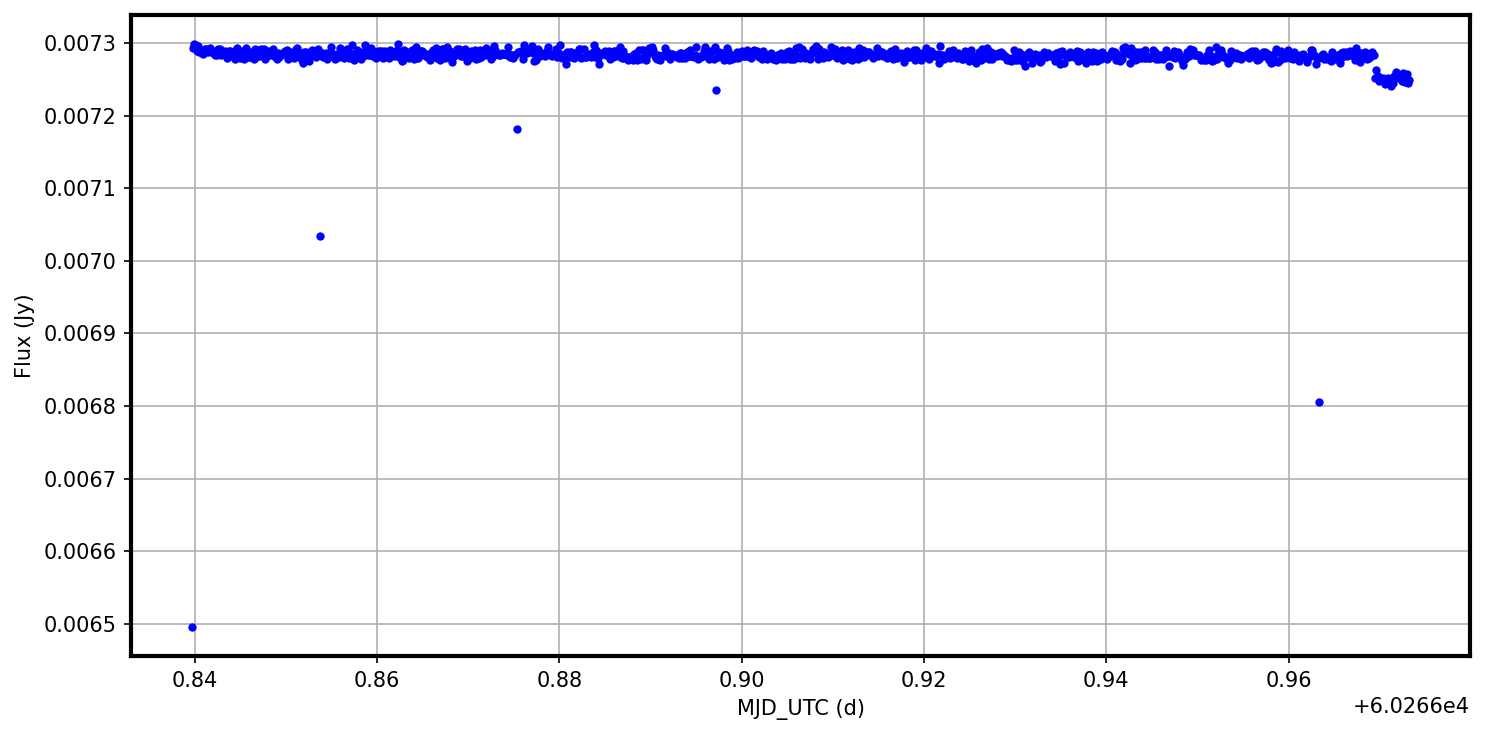

In [28]:
if do_viz:
    # Read in photometry file
    phot_file = os.path.join(tso3_dir, 'Stage3_phot.ecsv')
    data = ascii.read(phot_file, comment='#', delimiter=' ')

    # Make normal plots
    %matplotlib inline
    # Interactive plots
    #%matplotlib notebook

    # Plot result
    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
    ax.plot(data['MJD'], data['aperture_sum'], 'b.', ms=6)
    plt.xlabel('MJD_UTC (d)')
    plt.ylabel('Flux (Jy)')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(tso3_dir, 'imaging_tso_example_lc.png'))

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 